# ELITE exome data

In [1]:
# install.packages("tidyverse")
# install.packages("labeling",repos = "cran")
# install.packages("ggplot2",dependencies = T)
# install.packages("ggpointdensity",lib="~/R/packages3.5/",dependencies=T)
library(labeling,lib.loc = "~/R/packages3.5")
library(ggplot2,lib.loc = "~/R/packages3.5")
library(data.table)
library(labeling)
library(ggplot2)
library(ggpointdensity,lib.loc = "~/R/packages3.5")
suppressPackageStartupMessages(library(qqman))
library(corrplot)

corrplot 0.84 loaded


## Check basic stats of the ELITE exome datasets using plink

In [46]:
setwd("/oak/stanford/groups/euan/projects/elite/ukbb_exome/elite_analyze_vcf/")
freqs = fread("elite_exome.afreq",data.table=F,stringsAsFactors=F)
head(freqs)

#CHROM,ID,REF,ALT,ALT_FREQS,OBS_CT
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
1,chr1:10492:C:T,C,T,0.05421690,166
1,chr1:13273:G:C,G,C,0.17716500,508
1,chr1:13289:CCT:C,CCT,C,0.00398406,502
1,chr1:14671:G:C,G,C,0.00943396,424
1,chr1:14907:A:G,A,G,0.34134600,208
1,chr1:14930:A:G,A,G,0.40206200,194


In [47]:
hardy = fread("elite_exome.hardy",data.table=F,stringsAsFactors=F)
head(hardy)

#CHROM,ID,A1,AX,HOM_A1_CT,HET_A1_CT,TWO_AX_CT,O(HET_A1),E(HET_A1),P
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,chr1:10492:C:T,C,T,78,1,4,0.01204820,0.10255500,1.37258e-06
1,chr1:13273:G:C,G,C,180,58,16,0.22834600,0.29155600,1.06977e-03
1,chr1:13289:CCT:C,CCT,C,249,2,0,0.00796813,0.00793638,1.00000e+00
1,chr1:14671:G:C,G,C,209,2,1,0.00943396,0.01868990,1.41676e-02
1,chr1:14907:A:G,A,G,61,15,28,0.14423100,0.44965800,3.03663e-12
1,chr1:14930:A:G,A,G,52,12,33,0.12371100,0.48081600,3.45805e-14


In [48]:
missing = fread("elite_exome.vmiss",data.table=F,stringsAsFactors=F)
head(missing)

#CHROM,ID,MISSING_CT,OBS_CT,F_MISS
<chr>,<chr>,<int>,<int>,<dbl>
1,chr1:10492:C:T,184,267,0.6891390
1,chr1:13273:G:C,13,267,0.0486891
1,chr1:13289:CCT:C,16,267,0.0599251
1,chr1:14671:G:C,55,267,0.2059930
1,chr1:14907:A:G,163,267,0.6104870
1,chr1:14930:A:G,170,267,0.6367040


In [49]:
gcounts = fread("elite_exome.gcount",data.table=F,stringsAsFactors=F)
head(gcounts)

#CHROM,ID,REF,ALT,HOM_REF_CT,HET_REF_ALT_CTS,TWO_ALT_GENO_CTS,HAP_REF_CT,HAP_ALT_CTS,MISSING_CT
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr1:10492:C:T,C,T,78,1,4,0,0,184
1,chr1:13273:G:C,G,C,180,58,16,0,0,13
1,chr1:13289:CCT:C,CCT,C,249,2,0,0,0,16
1,chr1:14671:G:C,G,C,209,2,1,0,0,55
1,chr1:14907:A:G,A,G,61,15,28,0,0,163
1,chr1:14930:A:G,A,G,52,12,33,0,0,170


[1] 4724172

[1] 4552244

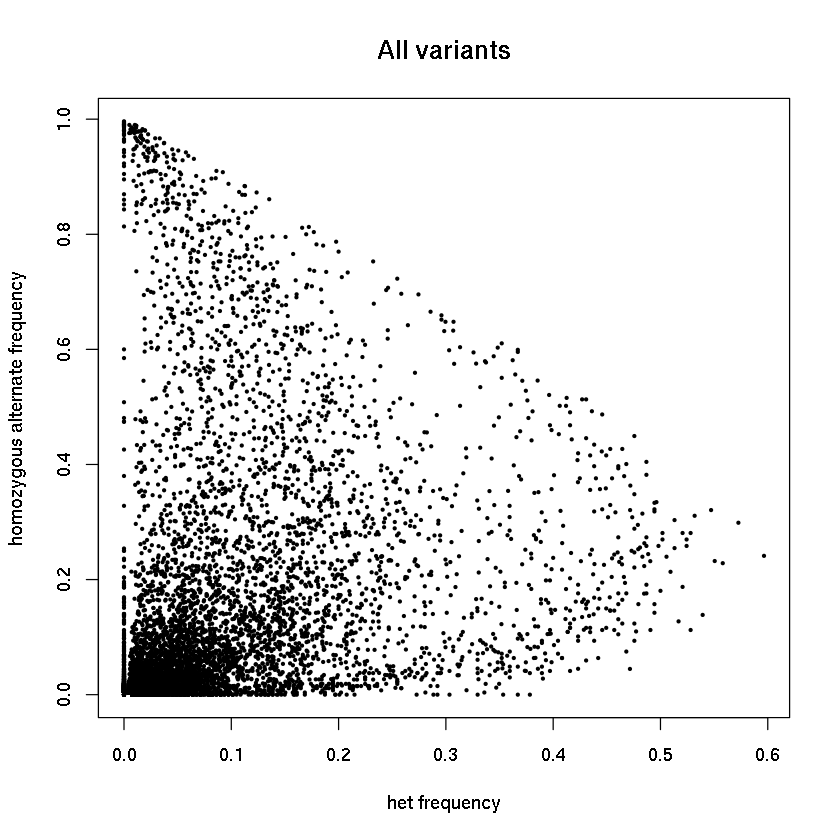

In [50]:
nrow(gcounts)
nrow(hardy)

g_avail_counts = (267 - gcounts$MISSING_CT)
summary_df = data.frame(
    ID = freqs$ID,
    g_avail_counts = g_avail_counts,
    het_freq = gcounts$HET_REF_ALT_CTS / g_avail_counts,
    minor_hom_freq = gcounts$TWO_ALT_GENO_CTS / g_avail_counts,
    mafs = freqs$ALT_FREQS,
    fmiss = missing$F_MISS,
    hwe_p = 1
)
rownames(summary_df) = summary_df$ID
summary_df[hardy$ID,"hwe_p"] = hardy$P

samp = sample(1:length(summary_df$het_freq))[1:10000]
plot(x = summary_df$het_freq[samp],summary_df$minor_hom_freq[samp],main="All variants",
    xlab = "het frequency", ylab = "homozygous alternate frequency",pch=20,cex=0.5)


  FALSE    TRUE 
2443166 2109078 


  FALSE    TRUE 
 965294 3749420 

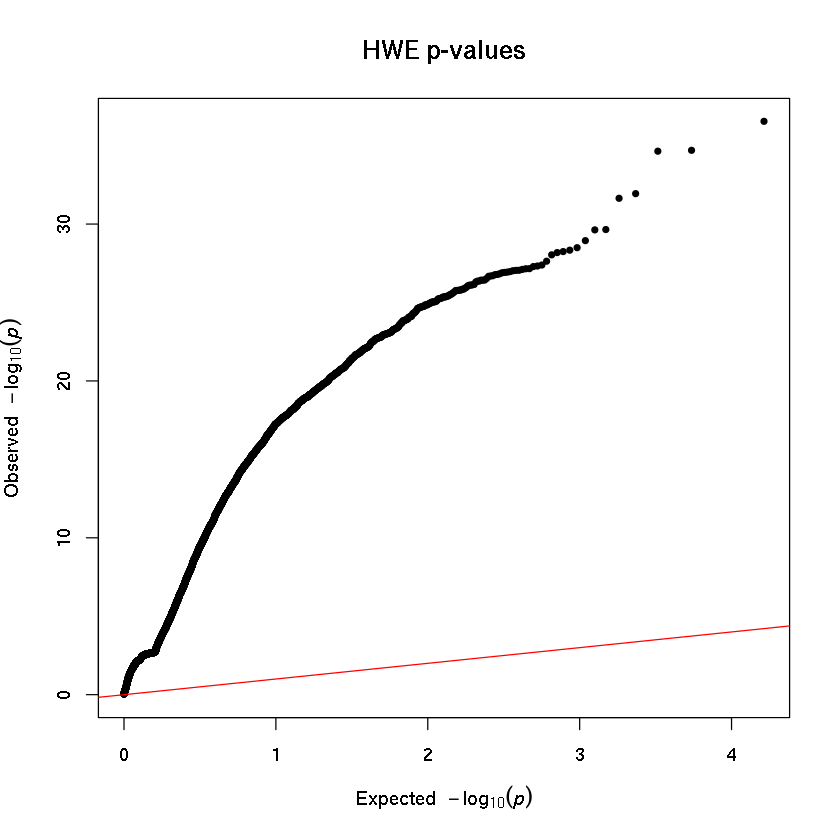

In [51]:
qq(hardy$P[samp],main="HWE p-values")
table(hardy$P<1e-04)
table(summary_df$hwe_p< 1e-04 | summary_df$mafs < 0.001 | summary_df$fmiss > 0.1)

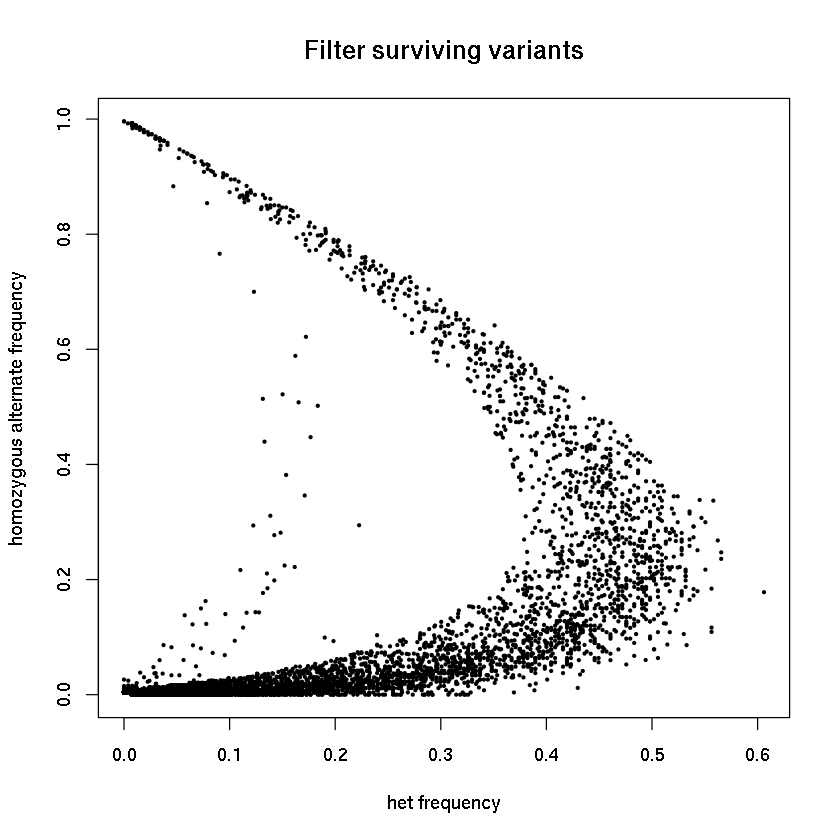

In [52]:
inds = summary_df$hwe_p< 1e-04 | summary_df$mafs < 0.001 | summary_df$fmiss > 0.1
inds = which(!inds)
samp = sample(inds)[1:10000]
plot(x = summary_df$het_freq[samp],summary_df$minor_hom_freq[samp],main="Filter surviving variants",
     xlab = "het frequency", ylab = "homozygous alternate frequency",pch=20,cex=0.5)

In [59]:
#rownames(summary_df)[1:10]
print(summary_df["chr19:54595848",])

                                   ID g_avail_counts  het_freq minor_hom_freq
chr19:54595848:T:C chr19:54595848:T:C            267 0.1947566     0.02247191
                      mafs fmiss    hwe_p
chr19:54595848:T:C 0.11985     0 0.237741


## PCA with UKBB: select EUs, examine PCs

In [2]:
# set the wd
setwd("/oak/stanford/groups/euan/projects/elite/ukbb_exome/beds/")
d = fread("ukbb_elite_merged.filtered.eigenvec",stringsAsFactors=F,data.table=F)
head(d)
d$is_elite = grepl("_",d$IID)
dim(d)
table(as.numeric(d$is_elite))

# table(d$class)
# boxplot(height~class,data=d)
# quantile(d[d$class==1,"height"])

#FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1,-1,-0.000904710,1.58322e-03,-0.000277371,-1.92920e-03,0.005067500,-0.003583770,0.00296473,0.00285268,-0.008053050,0.000526891
0,01_02,-0.000518797,-9.95376e-04,0.003647890,7.97161e-05,-0.001283380,-0.000300721,0.00315210,0.00280653,-0.000482419,-0.005057450
0,01_03,-0.000994941,3.43132e-04,0.000398093,-1.17622e-03,0.001871040,-0.000340352,0.00084905,-0.00345777,0.001509220,0.000502351
0,01_05,-0.000557747,-4.48522e-04,0.001193910,-9.56834e-04,0.001635500,-0.004906180,0.00261615,-0.00269032,-0.006115730,-0.005749390
0,01_06,-0.000725783,6.55897e-05,0.001859550,-8.53900e-04,0.003683130,-0.008297720,0.00470120,-0.00131836,0.001778600,0.000591852
0,01_07,-0.000660097,-1.11398e-03,0.001381730,-3.24960e-03,-0.000940202,-0.003057820,0.00935611,-0.00279663,0.000946573,-0.006993460


[1] 50227    13


    0     1 
49960   267 

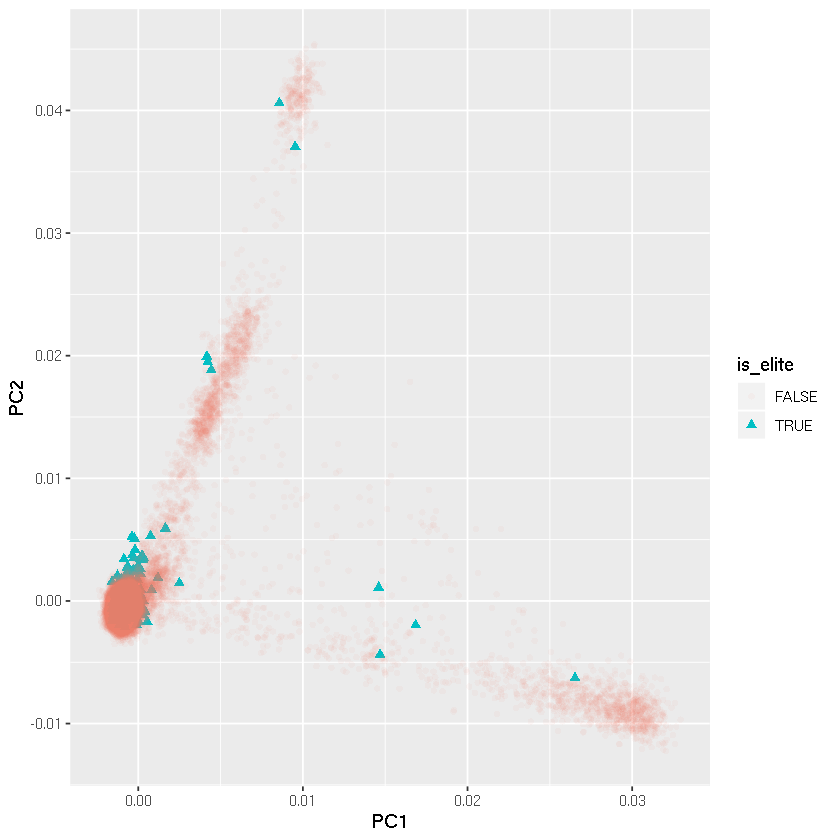

In [5]:
p = ggplot(d) + 
geom_point(aes(x=PC1, y=PC2,col=is_elite, shape=is_elite,alpha=is_elite,size=is_elite))+
scale_size_manual(values=c(1.5,2.0)) +
scale_alpha_manual(values=c(0.05,1))
plot(p)


[1] 50227    14

[1] 50227

[1] 50227

       
        FALSE  TRUE
  FALSE  2874     9
  TRUE  47086   258

#FID,IID
<int>,<chr>
-1,-1
0,01_02
0,01_03
0,01_05
0,01_06
0,01_07


[1] 47344     2

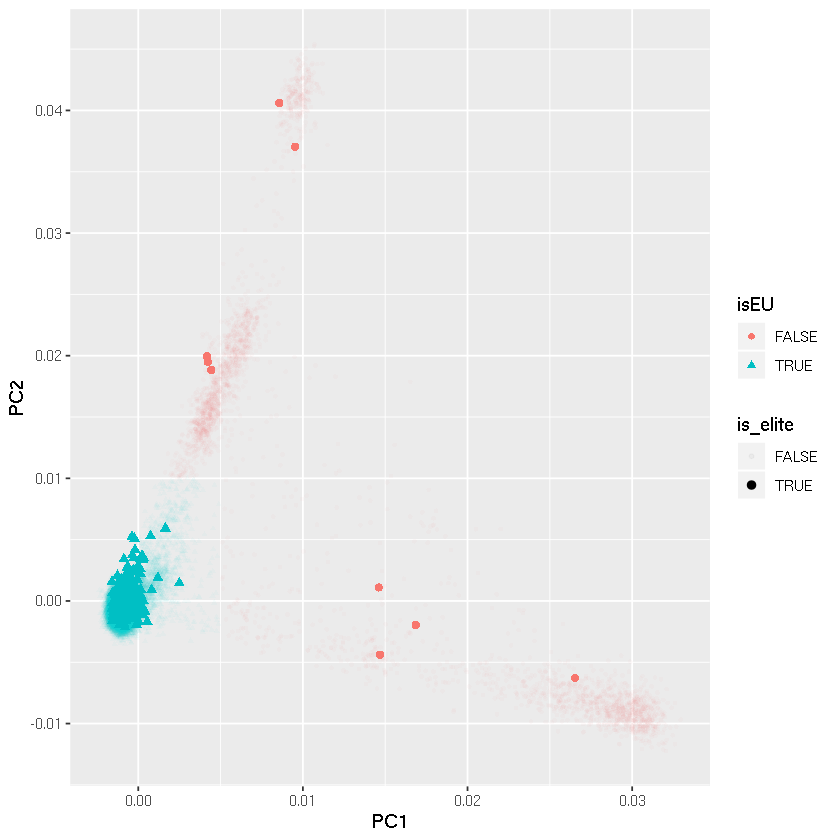

In [9]:
# define the EUs
d$isEU = d$PC1 < 0.005 & d$PC2 < 0.01
dim(d)
length(d$isEU)
length(d$is_elite)
table(d$isEU,d$is_elite)
p = ggplot(d) + 
geom_point(aes(x=PC1, y=PC2,col=isEU, shape=isEU,alpha=is_elite,size=is_elite))+
scale_size_manual(values=c(1.0,2.0)) +
scale_alpha_manual(values=c(0.03,1))
plot(p)

# Subset the fam file
eu_fam = d[d$isEU,1:2]
head(eu_fam)
dim(eu_fam)
fwrite(eu_fam,file="ukbb_elite_merged_EU.fam",sep="\t",row.names=F,col.names=T,quote=F)


## PCA: EUs

In [2]:
setwd("/oak/stanford/groups/euan/projects/elite/ukbb_exome/eu_beds/")
d = fread("merged_pheno.phe",stringsAsFactors=F,data.table=F)
head(d)
d$is_elite = grepl("_",d$IID)
dim(d)
table(as.numeric(d$is_elite))


#FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,⋯,PC19,PC20,sex,age,class,VO2,height,weight,BMI,ethnicity
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
-1,-1,-0.00545632,4.78873e-05,-0.021345100,-0.01384710,0.00436592,0.00558576,0.00928554,-0.00119717,⋯,-0.00439859,0.003276060,1,67,1,-9,-9,-9,-9.00000,-9
0,01_02,0.00236022,2.27016e-03,0.000388292,-0.00551510,-0.00767764,0.00386634,0.00411372,-0.00131577,⋯,-0.00705055,-0.014063900,2,25,2,83,-9,-9,22.37654,-9
0,01_03,-0.00135984,2.72962e-04,-0.001861500,-0.00103285,0.01633590,0.00287301,-0.00242657,-0.00461021,⋯,0.00437716,0.003712360,-9,-9,2,-9,-9,-9,-9.00000,-9
0,01_05,-0.00129507,-1.23039e-03,-0.013743100,0.00393984,0.00249883,-0.00817064,-0.00567485,0.00308920,⋯,-0.00603601,0.009042780,-9,-9,2,-9,-9,-9,-9.00000,-9
0,01_06,-0.00237632,3.14989e-03,-0.010767700,0.00311382,-0.00524562,-0.00755569,0.01569180,0.00983450,⋯,0.00400512,-0.000202691,-9,-9,2,-9,-9,-9,-9.00000,-9
0,01_07,-0.00206116,-4.27599e-05,-0.000978138,-0.00574859,-0.00261691,0.01451310,0.00362281,-0.00326040,⋯,-0.00202504,0.000523075,1,25,2,67,-9,-9,19.17355,-9


[1] 37346    31


    0     1 
37088   258 

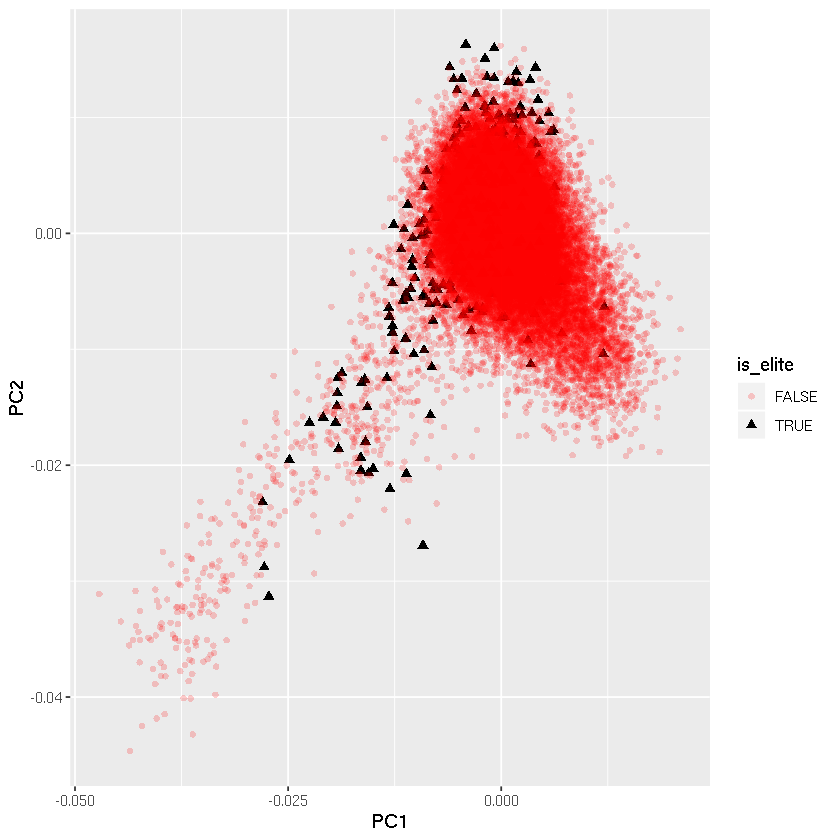

In [3]:
p = ggplot(d) + 
geom_point(aes(x=PC1, y=PC2,col=is_elite, shape=is_elite,alpha=is_elite,size=is_elite))+
scale_size_manual(values=c(1.5,2.0)) +
scale_alpha_manual(values=c(0.2,1)) + 
scale_color_manual(values=c("red","black"))
plot(p)

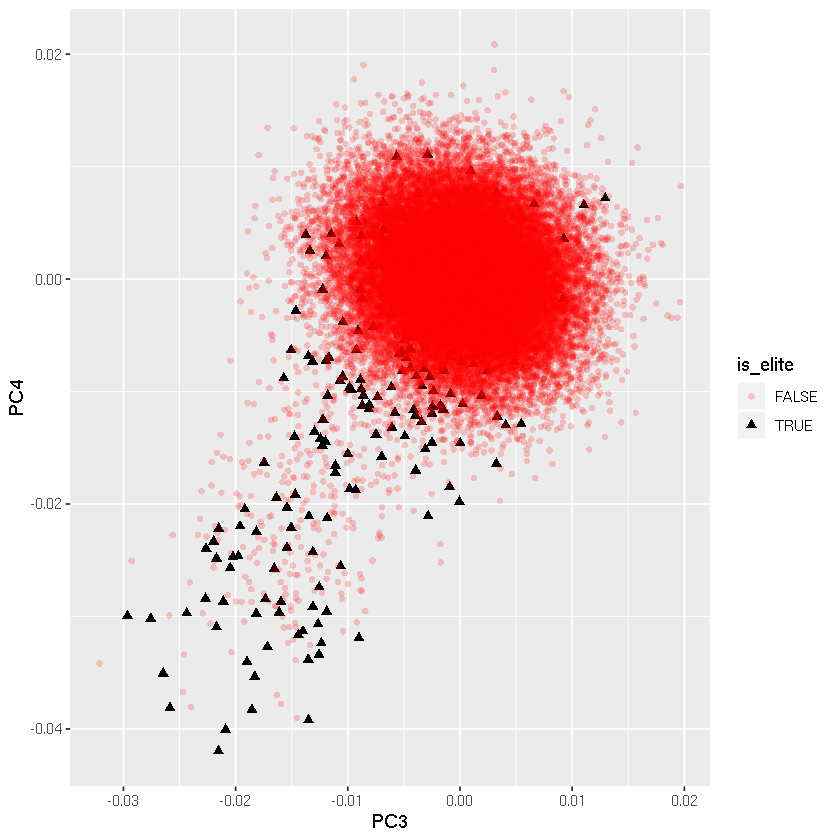

In [4]:
p = ggplot(d) + 
geom_point(aes(x=PC3,y=PC4,col=is_elite, shape=is_elite,alpha=is_elite,size=is_elite))+
scale_size_manual(values=c(1.5,2.0)) +
scale_alpha_manual(values=c(0.2,1)) + 
scale_color_manual(values=c("red","black"))
plot(p)

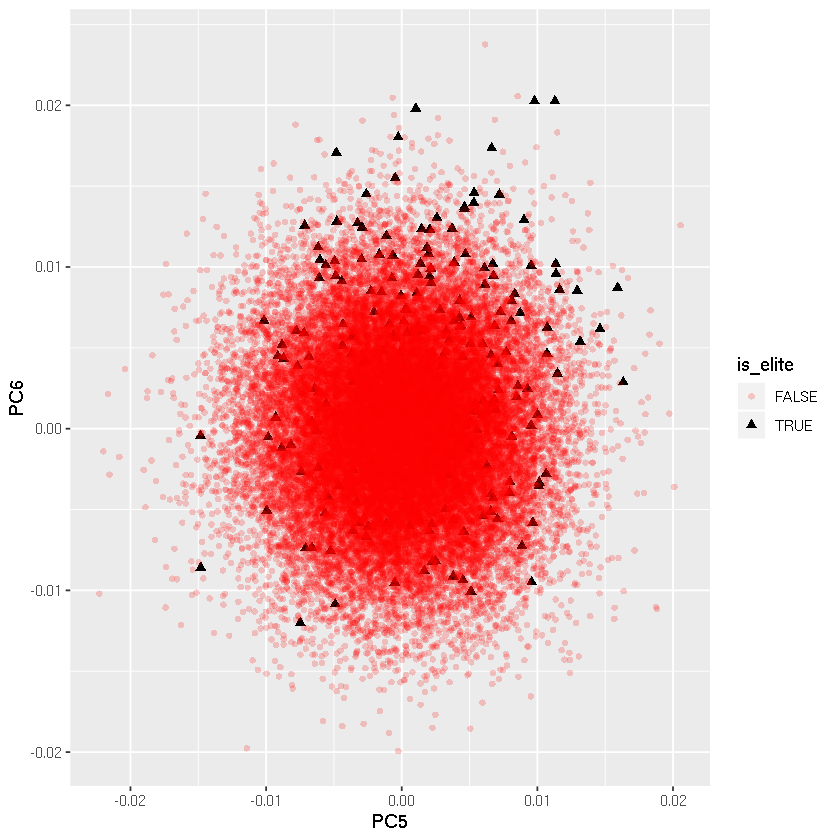

In [5]:
p = ggplot(d) + 
geom_point(aes(x=PC5, y=PC6,col=is_elite, shape=is_elite,alpha=is_elite,size=is_elite))+
scale_size_manual(values=c(1.5,2.0)) +
scale_alpha_manual(values=c(0.2,1)) + 
scale_color_manual(values=c("red","black"))
plot(p)

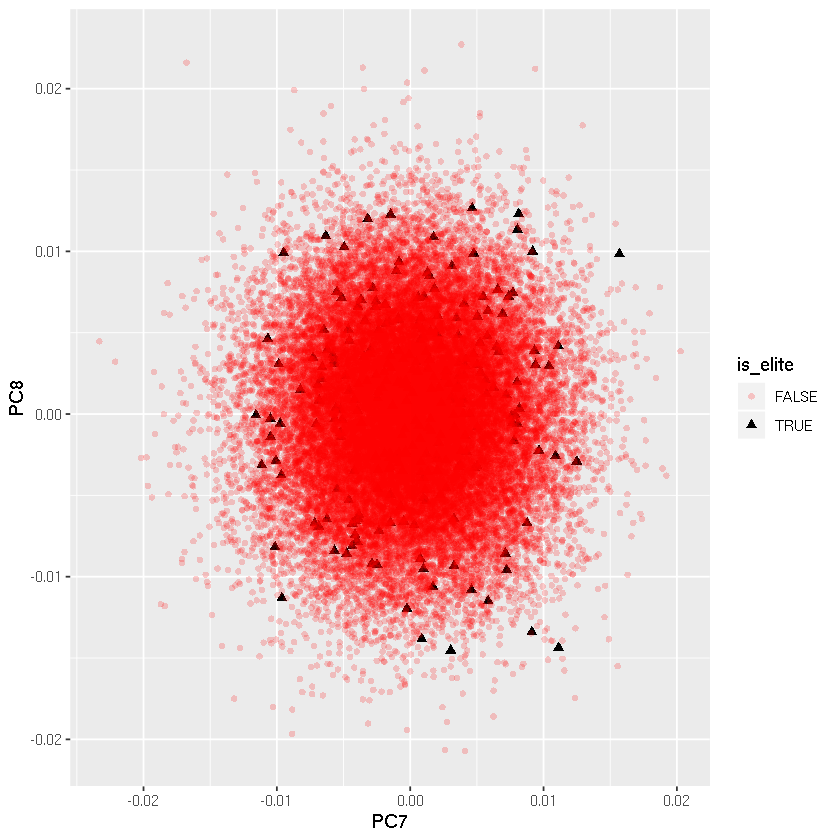

In [6]:
p = ggplot(d) + 
geom_point(aes(x=PC7, y=PC8,col=is_elite, shape=is_elite,alpha=is_elite,size=is_elite))+
scale_size_manual(values=c(1.5,2.0)) +
scale_alpha_manual(values=c(0.2,1)) + 
scale_color_manual(values=c("red","black"))
plot(p)

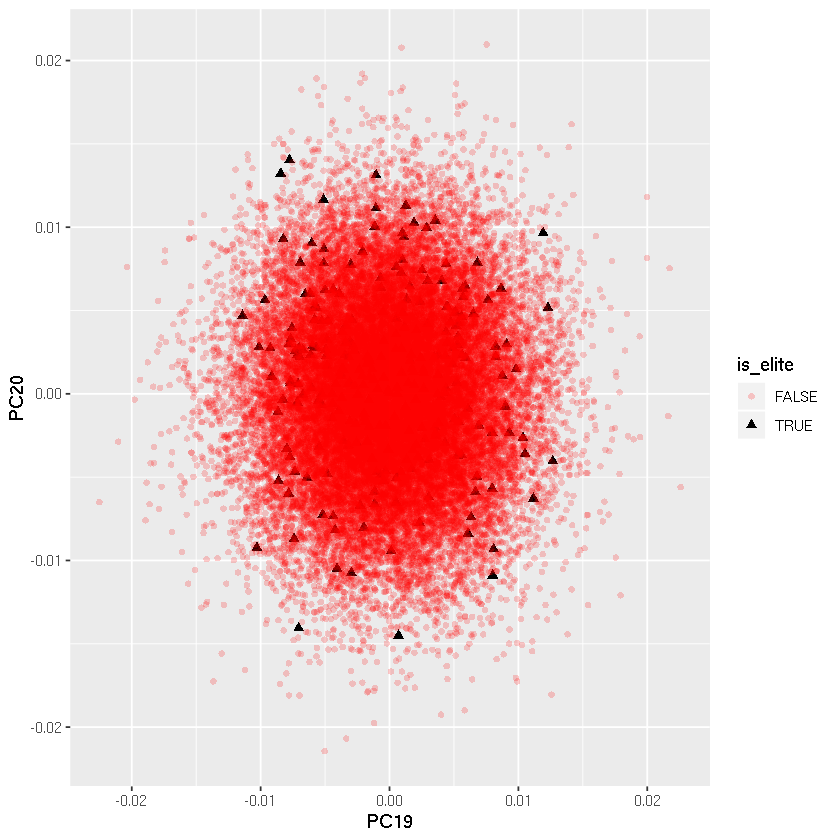

In [7]:
p = ggplot(d) + 
geom_point(aes(x=PC19, y=PC20,col=is_elite, shape=is_elite,alpha=is_elite,size=is_elite))+
scale_size_manual(values=c(1.5,2.0)) +
scale_alpha_manual(values=c(0.2,1)) + 
scale_color_manual(values=c("red","black"))
plot(p)

## Define the intra EU group

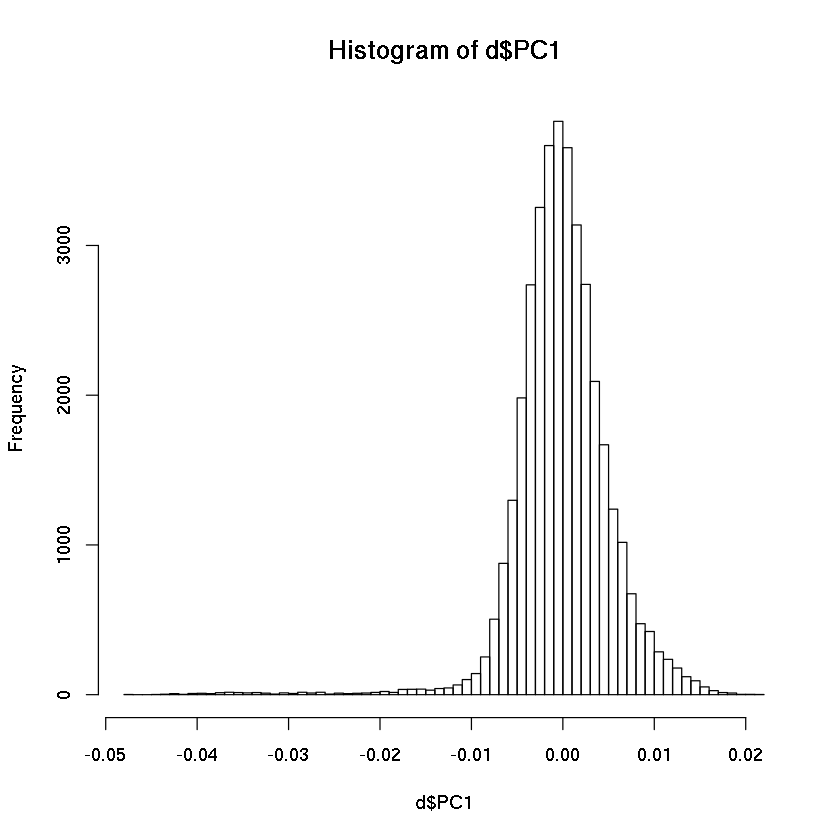

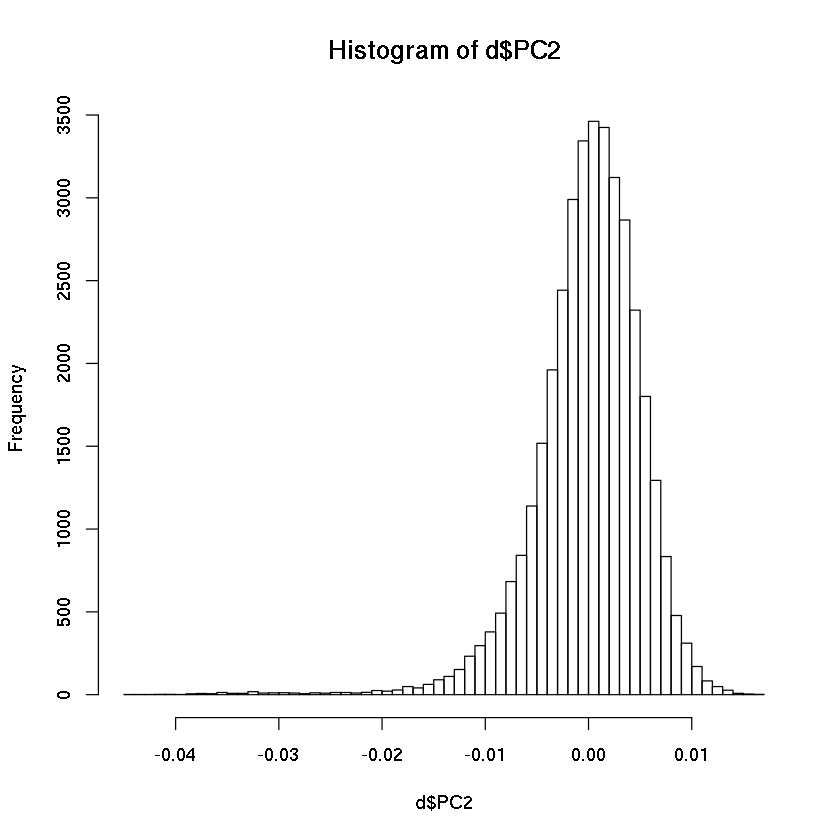

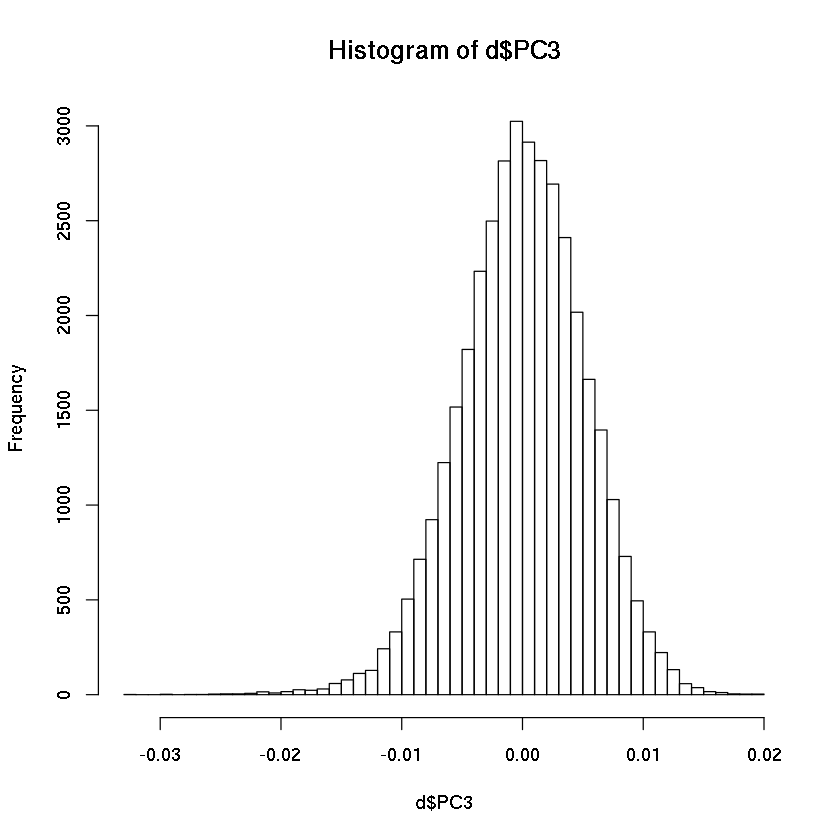

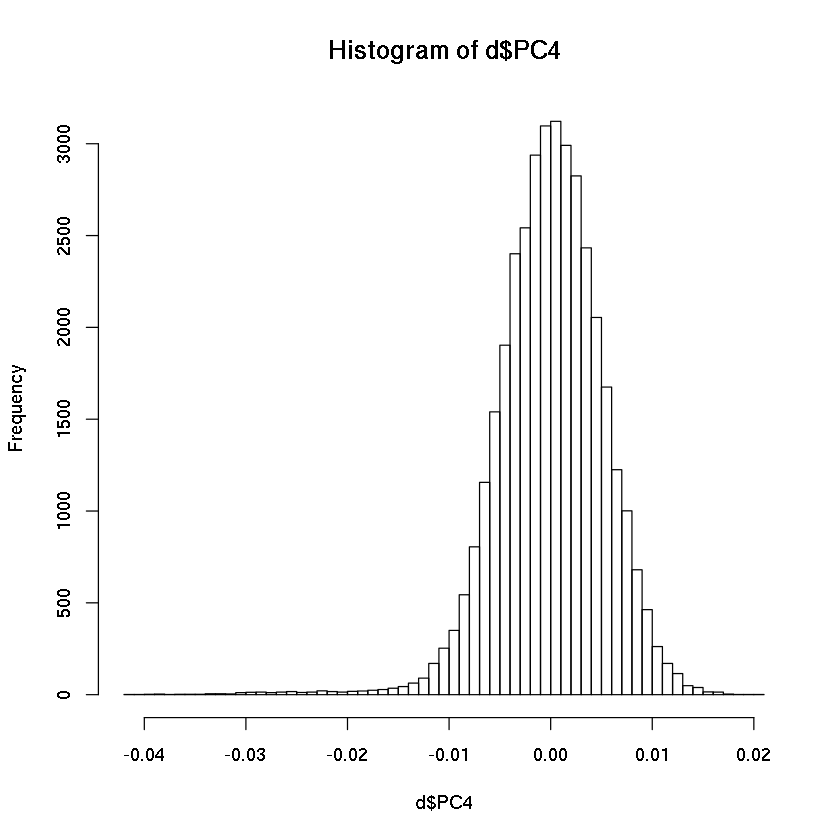

In [6]:
hist(d$PC1,breaks=50)
hist(d$PC2,breaks=50)
hist(d$PC3,breaks=50)
hist(d$PC4,breaks=50)

PC1,PC2,PC3,PC4
"(-0.00623,-0.00282]","(-0.00199,0.00105]","(-0.0218,-0.0192]","(-0.0168,-0.0137]"
"(0.000592,0.004]","(0.00105,0.0041]","(-0.00106,0.00153]","(-0.00741,-0.00427]"
"(-0.00282,0.000592]","(-0.00199,0.00105]","(-0.00365,-0.00106]","(-0.00113,0.00201]"
"(-0.00282,0.000592]","(-0.00199,0.00105]","(-0.014,-0.0114]","(0.00201,0.00515]"
"(-0.00282,0.000592]","(0.00105,0.0041]","(-0.0114,-0.00883]","(0.00201,0.00515]"
"(-0.00282,0.000592]","(-0.00199,0.00105]","(-0.00106,0.00153]","(-0.00741,-0.00427]"


       
        FALSE  TRUE
  FALSE  1830   129
  TRUE  35258   129

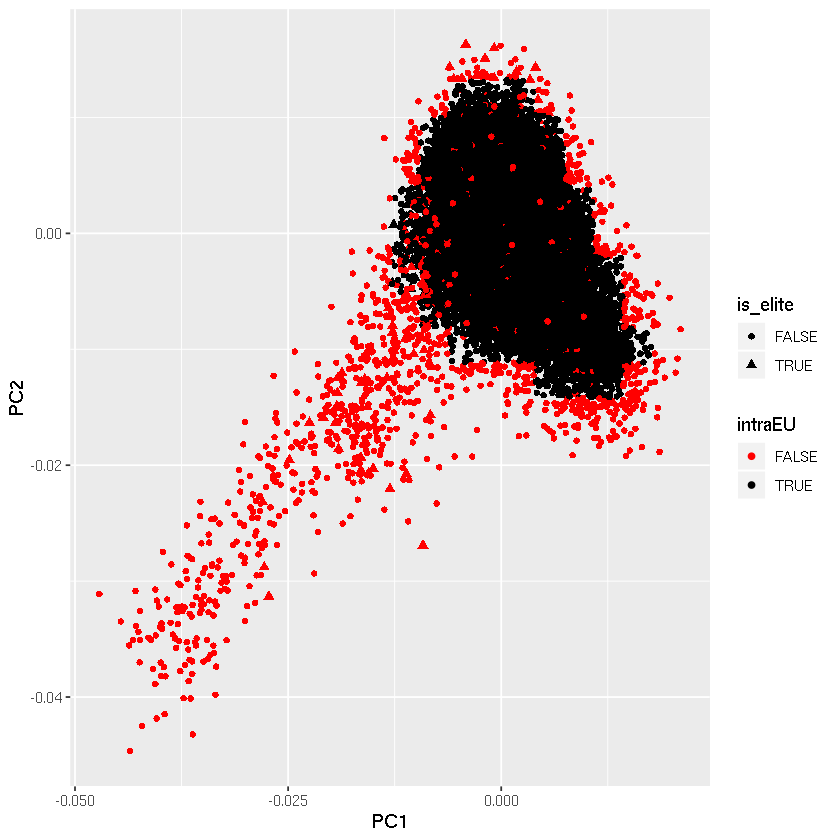

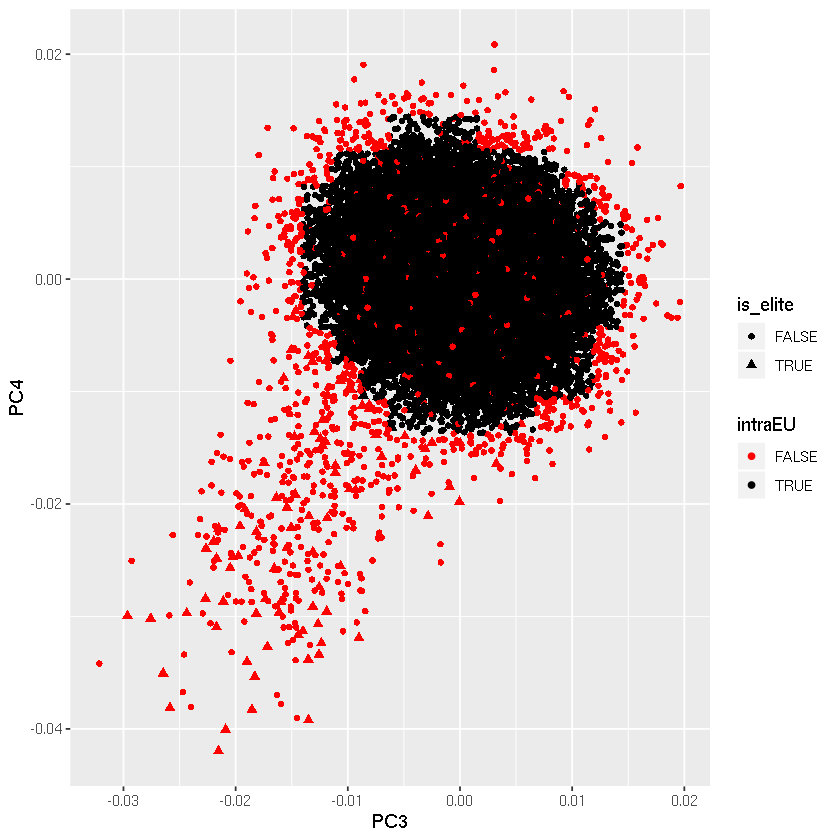

In [27]:
pcs1_4_disc = apply(d[,paste0("PC",1:4)],2,cut,breaks=20)
head(pcs1_4_disc)
tb1 = paste(pcs1_4_disc[,1],pcs1_4_disc[,2])
nonoutliers_tb1 = names(which(table(tb1) > 35))
tb2 = paste(pcs1_4_disc[,3],pcs1_4_disc[,4])
nonoutliers_tb2 = names(which(table(tb2) > 35))

d$intraEU = tb1 %in% nonoutliers_tb1 & tb2 %in% nonoutliers_tb2

table(d$intraEU,d$is_elite)

p = ggplot(d) + 
geom_point(aes(x=PC1, y=PC2,col=intraEU, shape=is_elite,size=is_elite))+
scale_size_manual(values=c(1.5,2.0)) +
scale_alpha_manual(values=c(0.2,1)) + 
scale_color_manual(values=c("red","black"))
plot(p)
p = ggplot(d) + 
geom_point(aes(x=PC3, y=PC4,col=intraEU, shape=is_elite,size=is_elite))+
scale_size_manual(values=c(1.5,2.0)) +
scale_alpha_manual(values=c(0.2,1)) + 
scale_color_manual(values=c("red","black"))
plot(p)


intraeu_fam = d[d$intraEU,1:2]
fwrite(intraeu_fam,
    file="/oak/stanford/groups/euan/projects/elite/ukbb_exome/ukbb_elite_merged_rivaslabEU_intra.fam",
    sep="\t",row.names=F,col.names=T,quote=F)
intraeu_fam2 = d[!d$intraEU,1:2]
fwrite(intraeu_fam2,
    file="/oak/stanford/groups/euan/projects/elite/ukbb_exome/ukbb_elite_merged_rivaslabEU_intra_others.fam",
    sep="\t",row.names=F,col.names=T,quote=F)


## Sanity check: PCA on EU ukbb variants alone

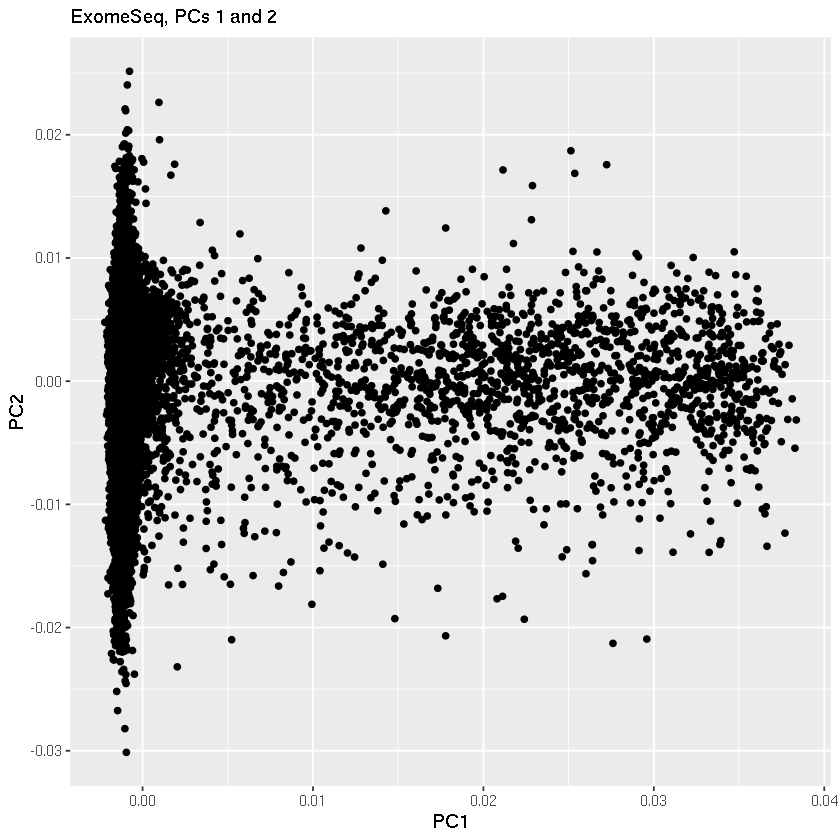

In [25]:
d2 = fread(
    "/oak/stanford/groups/euan/projects/elite/ukbb_exome/ukbb_analyze_pgen/eu_rivaslab/eu_pca.eigenvec",
    data.table=F,stringsAsFactors=F
)
p = ggplot(d2) + geom_point(aes(x=PC1,y=PC2))+ ggtitle("ExomeSeq, PCs 1 and 2")
plot(p)

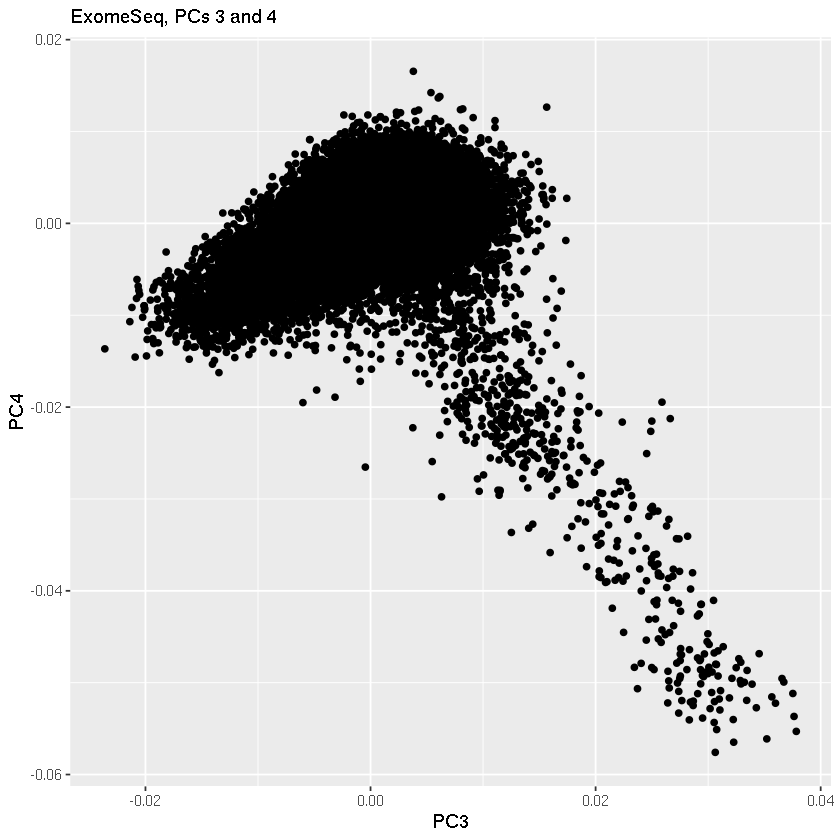

In [26]:
p = ggplot(d2) + geom_point(aes(x=PC3,y=PC4)) + ggtitle("ExomeSeq, PCs 3 and 4")
plot(p)

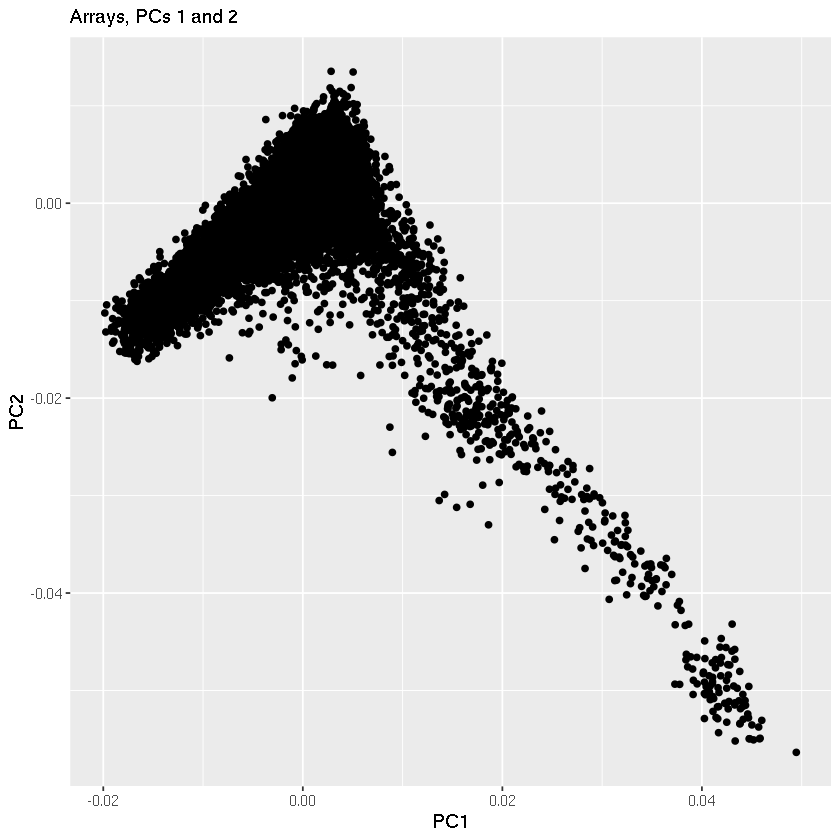

In [27]:
d3 = fread(
    "/oak/stanford/groups/euan/projects/elite/ukbb_exome/ukbb_analyze_pgen/eu_rivaslab_arrays/eu_pca.eigenvec",
    data.table=F,stringsAsFactors=F
)
p = ggplot(d3) + geom_point(aes(x=PC1,y=PC2))+ ggtitle("Arrays, PCs 1 and 2")
plot(p)

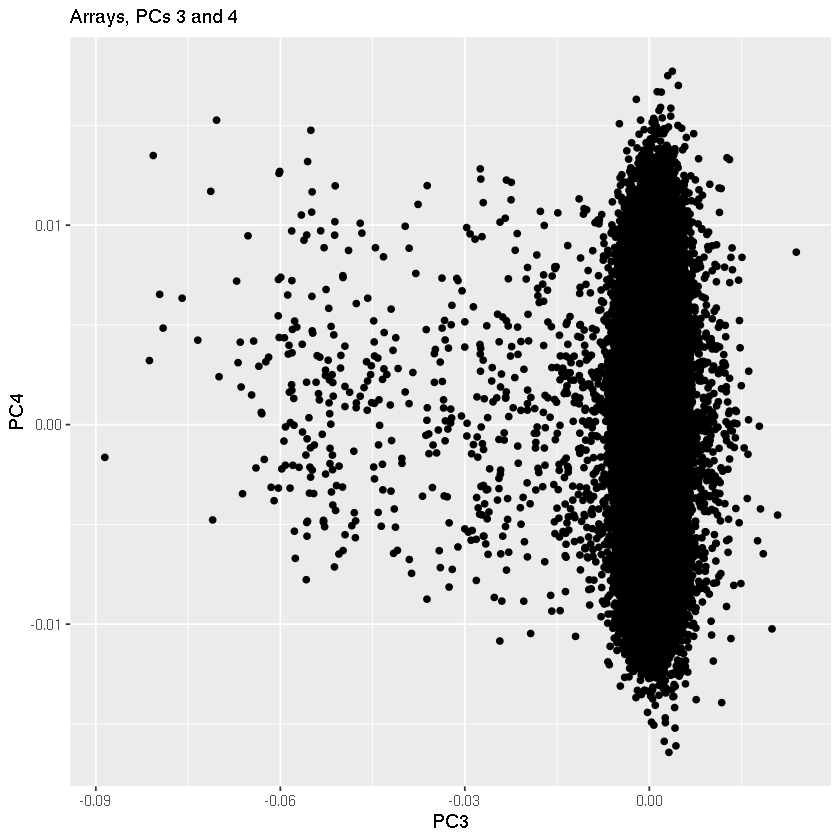

In [28]:
p = ggplot(d3) + geom_point(aes(x=PC3,y=PC4))+ ggtitle("Arrays, PCs 3 and 4")
plot(p)

In [29]:
rownames(d2) = as.character(d2[,2])
rownames(d3) = as.character(d3[,2])
d3 = d3[rownames(d2),]
d2 = d2[,-c(1:2)]
d3 = d3[,-c(1:2)]
d1 = d
rownames(d1) = as.character(d1[,2])
d1 = d1[rownames(d2),-c(1:2)]
colnames(d2) = paste("Seq",colnames(d2))
colnames(d3) = paste("Arrays",colnames(d3))
colnames(d1) = paste("Seq+Elite",colnames(d1))

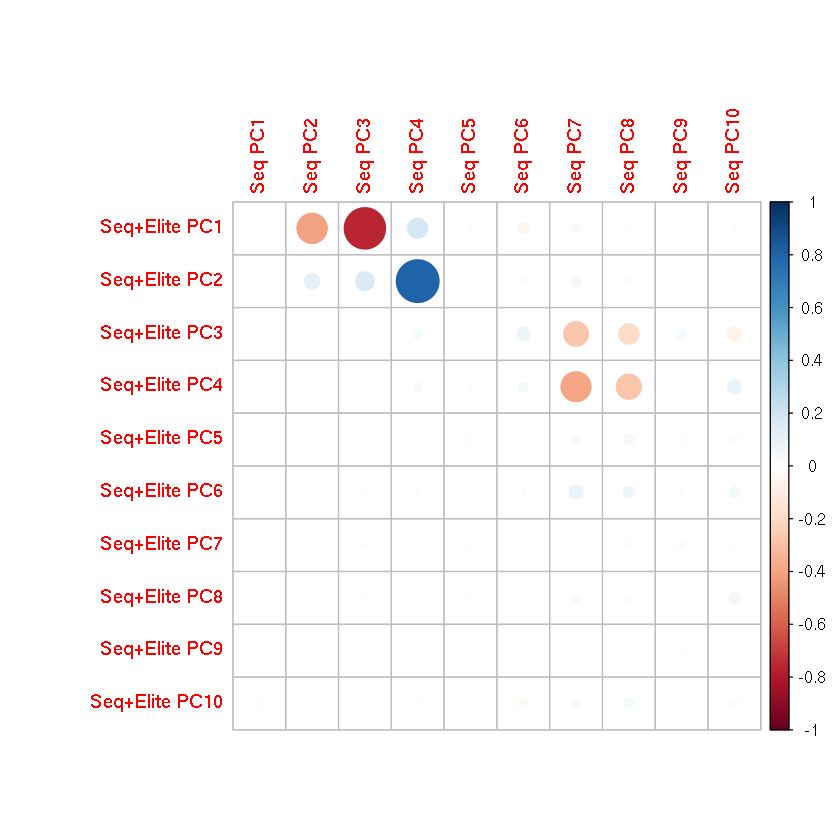

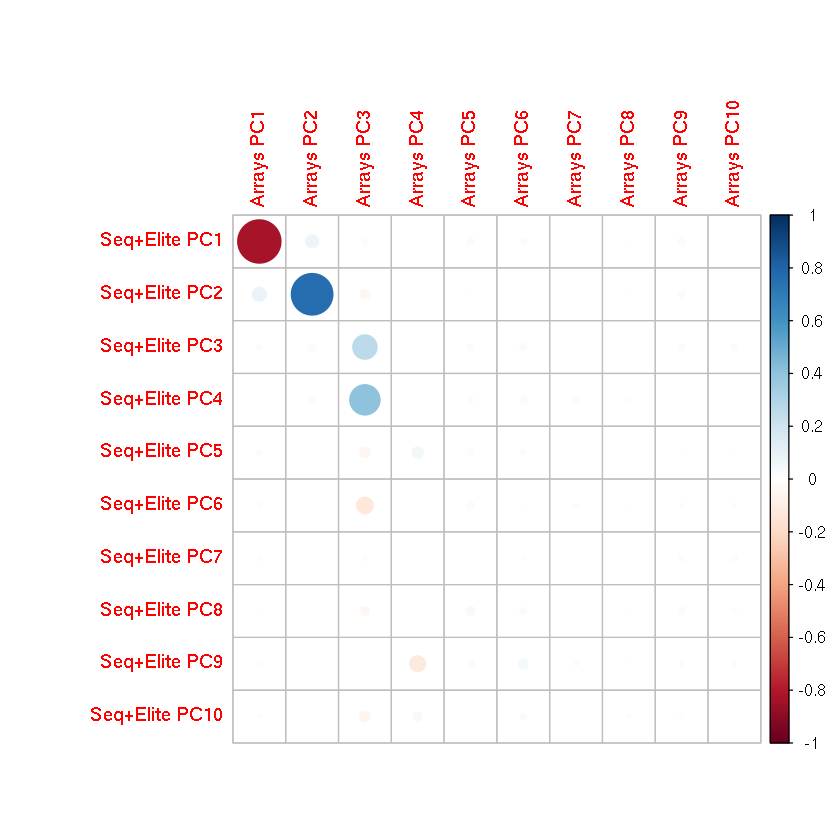

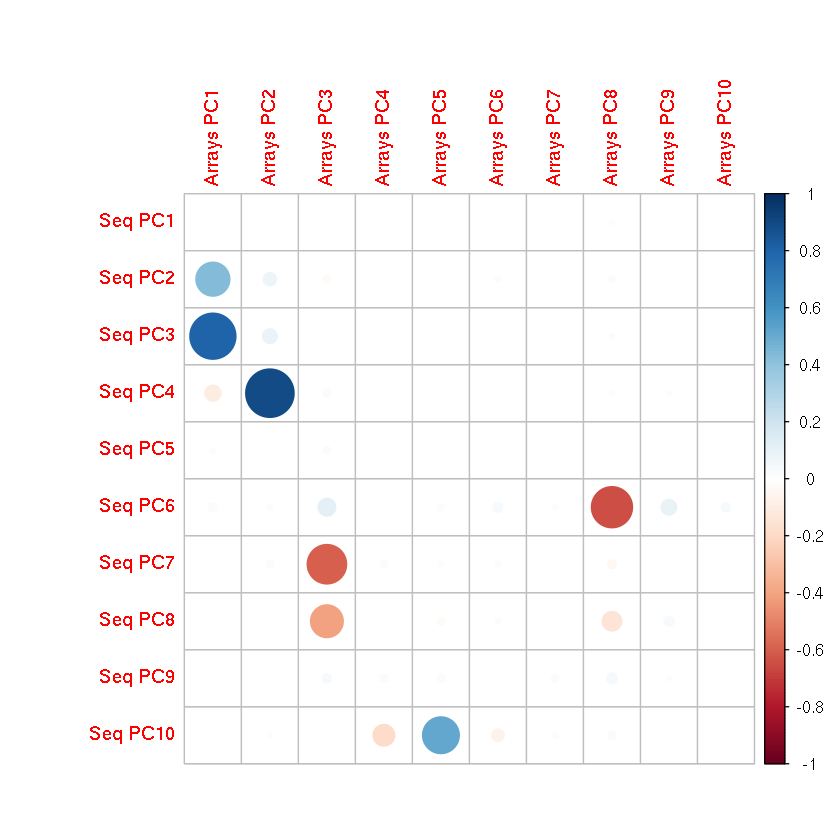

In [30]:
corrs1_2 = cor(d1[,1:10],d2)
corrs1_3 = cor(d1[,1:10],d3)
corrs2_3 = cor(d2,d3)
corrplot(corrs1_2)
corrplot(corrs1_3)
corrplot(corrs2_3)

# Use EU PCAs to define EU subgroups

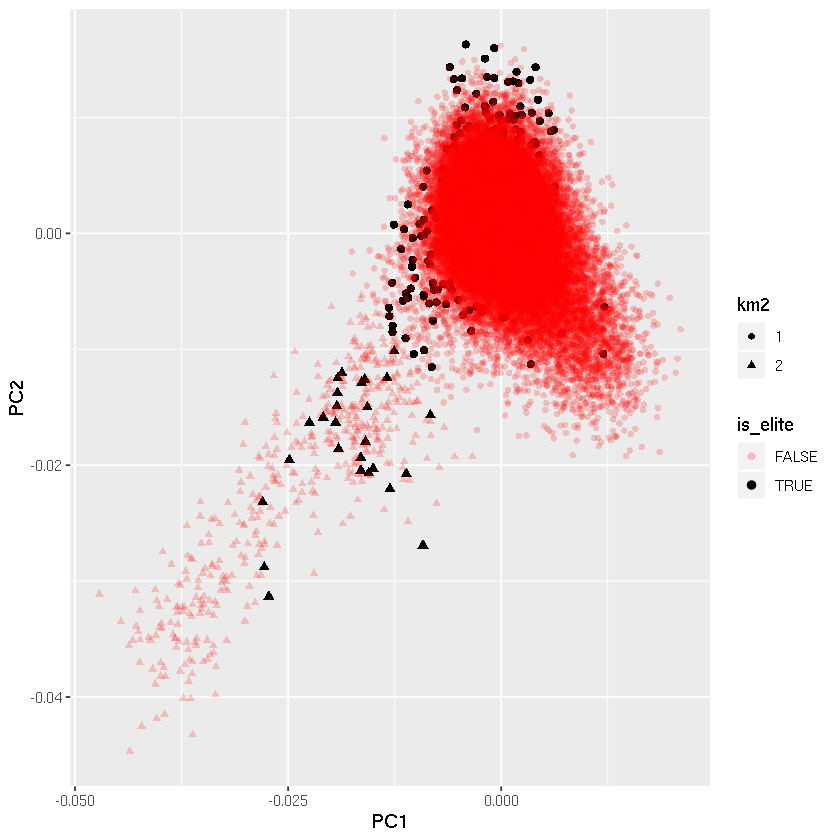

In [36]:
eu_pcs = d[,c("PC1","PC2","PC3")]
km2 = kmeans(eu_pcs[,1:2],rbind(c(0,0),c(-0.02,-0.02)))$cluster
d$km2 = as.factor(km2)
p = ggplot(d) + 
geom_point(aes(x=PC1, y=PC2,col=is_elite, shape=km2,alpha=is_elite,size=is_elite))+
scale_size_manual(values=c(1.5,2.0)) +
scale_alpha_manual(values=c(0.2,1)) + 
scale_color_manual(values=c("red","black"))
plot(p)

In [38]:
# Add country information
country_info = fread(
    "/oak/stanford/groups/euan/projects/elite/ukbb_exome/ukbb_analyze_pgen/ukb2005693_ukb37855.fields1647_20115.tsv",
    data.table=F,stringsAsFactors=F
)
country_codes = fread(
    "/oak/stanford/groups/euan/projects/elite/ukbb_exome/ukbb_analyze_pgen/ukb2005693_ukb37855.country_of_birth.coding.tsv",
    data.table=F,stringsAsFactors=F
)

code2str = country_codes[,"meaning"]
names(code2str) = country_codes[,"#field_val"]

is1647 = country_info[,"field"] == "1647"
country_v1 = paste(country_info[is1647,"field"],country_info[is1647,"val"],sep="_")
country_v1 = code2str[country_v1]
names(country_v1) = as.character(country_info[is1647,1])
country_v2 = paste(country_info[!is1647,"field"],country_info[!is1647,"val"],sep="_")
country_v2 = code2str[country_v2]
names(country_v2) = as.character(country_info[!is1647,1])

country_v = country_v2
specific1647 = setdiff(names(country_v1),names(country_v2))
country_v[specific1647] = country_v1[specific1647]
d$country = country_v[as.character(d[,2])]

In [ ]:
# PCs vs. countries
PCvsCountry_ps = c()
for(pc in 1:5){
    res = c()
    for(co in unique(d$country)){
        inds = d$country == co
        inds[is.na(inds)] = F
        if(sum(inds)<30){next}
        v = d[,paste0("PC",pc)]
        v1 = v[inds];v2=v[!inds]
        res[co] = t.test(v1,v2)$p.value
    }
    PCvsCountry_ps = rbind(PCvsCountry_ps,res)
}


## Missingness in the merged dataset

In [ ]:
ukbb_miss = fread("ukbb_elite_merged.filtered.ukbb.vmiss",data.table=F)
elite_miss = fread("ukbb_elite_merged.filtered.elite.vmiss",data.table=F)
head(ukbb_miss)
all(ukbb_miss$ID==elite_miss$ID)

In [ ]:
vmiss = data.frame(ELITE=elite_miss$F_MISS,UKB=ukbb_miss$F_MISS)
vmisslog = data.frame(ELITE=log10(elite_miss$F_MISS),UKB=log10(ukbb_miss$F_MISS))
ggplot(vmisslog, aes(x=ELITE, y=UKB)) + geom_pointdensity() + scale_color_viridis_c()

# GWAS

In [12]:
setwd("/oak/stanford/groups/euan/projects/elite/ukbb_exome/gwas")
gwasres = fread("naive_gwas.class.glm.logistic.hybrid",data.table = F,stringsAsFactors = F)
#gwasres = fread("vo2.VO2.glm.linear",data.table = F,stringsAsFactors = F)
gwasres = gwasres[!is.na(gwasres$P),]
names(gwasres)[1] = "CHR"
colnames(gwasres)[2] = "BP"
gwasres$SNP = gwasres$ID
head(gwasres)

CHR,BP,ID,REF,ALT,A1,FIRTH?,TEST,OBS_CT,OR,LOG(OR)_SE,Z_STAT,P,ERRCODE,SNP
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,942934,1:942934:G:C,G,C,C,N,ADD,37345,1.309460,0.1388250,1.9421300,0.0521219,.,1:942934:G:C
1,944296,1:944296:G:A,G,A,G,N,ADD,37346,1.221900,0.1792940,1.1177800,0.2636620,.,1:944296:G:A
1,944307,1:944307:T:C,T,C,T,N,ADD,37346,1.094020,0.1901370,0.4726120,0.6364900,.,1:944307:T:C
1,946247,1:946247:G:A,G,A,G,N,ADD,37344,1.239690,0.0908729,2.3644300,0.0180577,.,1:946247:G:A
1,946538,1:946538:G:A,G,A,A,N,ADD,37346,0.937567,0.1784660,-0.3612300,0.7179280,.,1:946538:G:A
1,952421,1:952421:A:G,A,G,A,N,ADD,37344,1.006010,0.1963560,0.0305217,0.9756510,.,1:952421:A:G


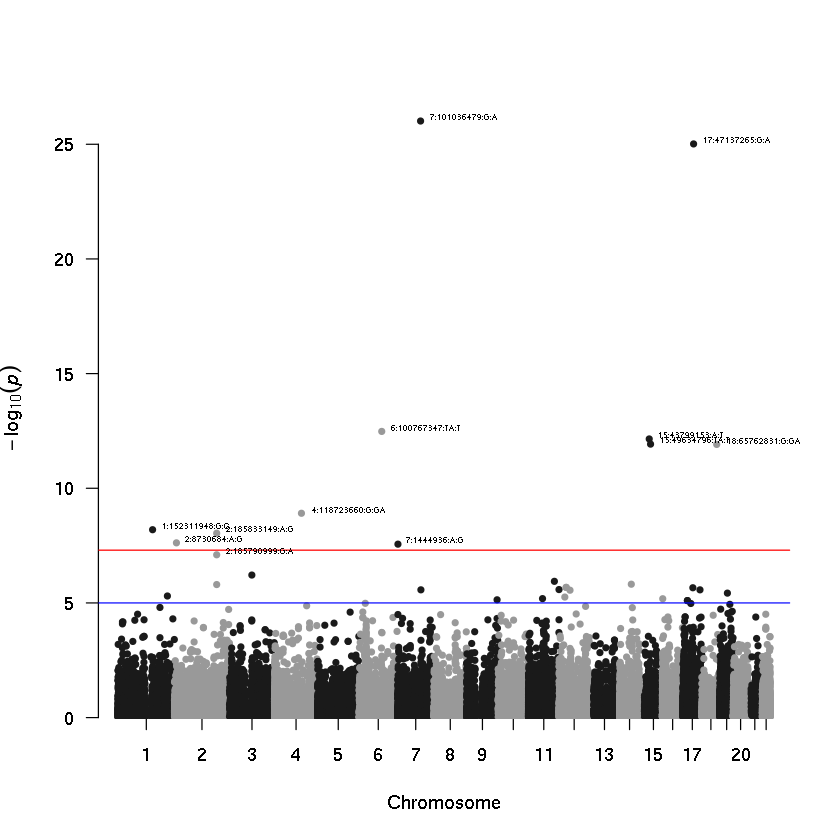

In [15]:
manhattan(gwasres,annotateTop=F,annotatePval=1e-7)

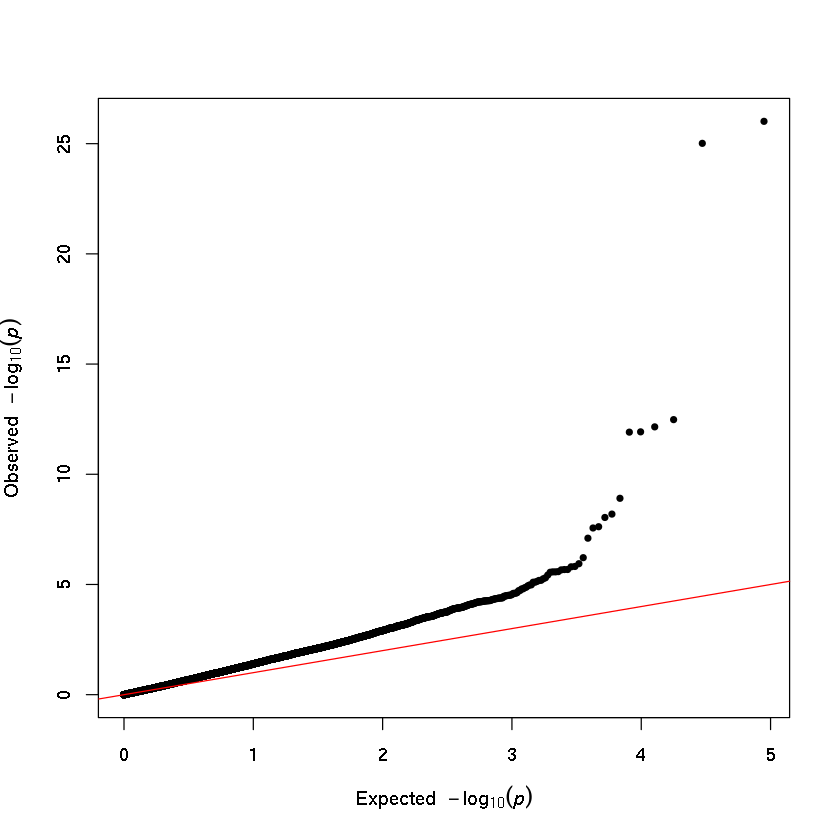

In [14]:
qq(gwasres$P)

,CHR,BP,ID,REF,ALT,A1,FIRTH?,TEST,OBS_CT,OR,LOG(OR)_SE,Z_STAT,P,ERRCODE,SNP
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
17356,7,101036479,7:101036479:G:A,G,A,A,N,ADD,37346,6.638200,0.1768260,10.70450,9.69255e-27,.,7:101036479:G:A
36130,17,47137265,17:47137265:G:A,G,A,A,N,ADD,37346,4.787840,0.1493010,10.48940,9.66172e-26,.,17:47137265:G:A
15311,6,100767347,6:100767347:TA:T,TA,T,TA,N,ADD,37313,15.571000,0.3770750,7.28080,3.31838e-13,.,6:100767347:TA:T
31513,15,43799153,15:43799153:A:T,A,T,A,N,ADD,37298,24.472100,0.4454580,7.17809,7.06934e-13,.,15:43799153:A:T
31582,15,49634796,15:49634796:TA:T,TA,T,T,N,ADD,37316,3.730080,0.1852390,7.10667,1.18880e-12,.,15:49634796:TA:T
37820,18,65762831,18:65762831:G:GA,G,GA,GA,N,ADD,37334,3.437960,0.1738710,7.10226,1.22735e-12,.,18:65762831:G:GA
11016,4,118723660,4:118723660:G:GA,G,GA,GA,N,ADD,37336,2.530530,0.1527990,6.07613,1.23118e-09,.,4:118723660:G:GA
2457,1,152311948,1:152311948:G:C,G,C,C,N,ADD,37346,2.835510,0.1795180,5.80567,6.41086e-09,.,1:152311948:G:C
6388,2,185833149,2:185833149:A:G,A,G,A,N,ADD,37346,15.250400,0.4741450,5.74636,9.11833e-09,.,2:185833149:A:G


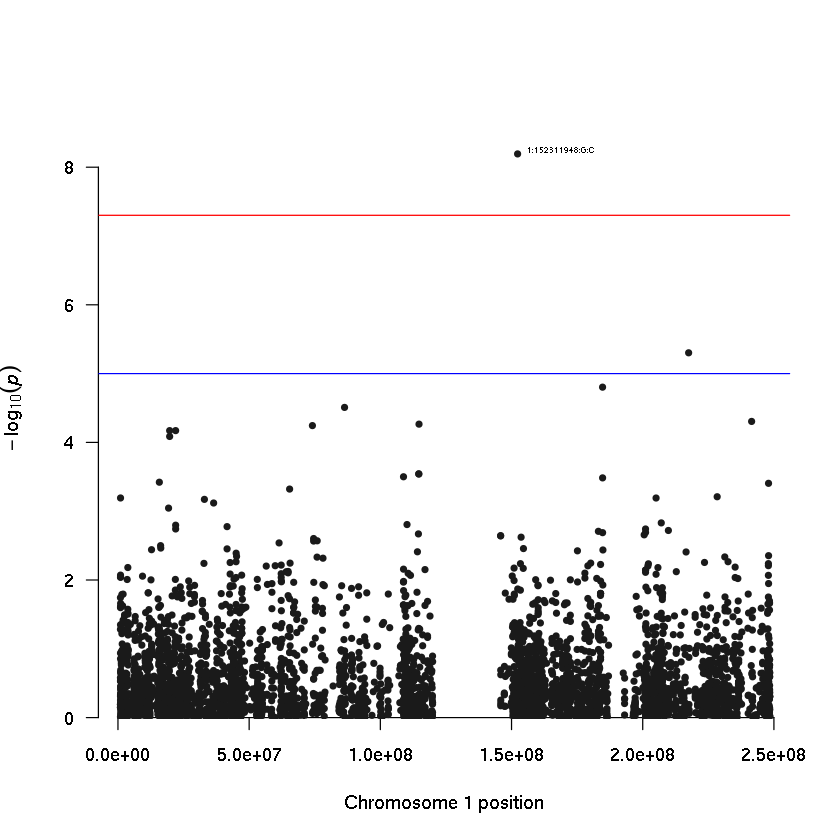

In [16]:
gwasres = gwasres[order(as.numeric(gwasres$P),decreasing = F),]
head(gwasres,30)
manhattan(subset(gwasres,CHR==1),annotateTop=F,annotatePval=1e-8)

In [5]:
# helper functions for reading and filtering the annotation data
install.packages("hash")
library(parallel);library(hash)
my.read.lines2=function(fname) {
 s = file.info( fname )$size 
 buf = readChar( fname, s, useBytes=T)
 strsplit( buf,"\n",fixed=T,useBytes=T)[[1]]
}
filter_line_by_hashkeys<-function(line,cols,sep="\t",ids_hash){
    arr=strsplit(line,split=sep)[[1]][cols]
    id = paste(arr,collapse=sep)
    return(has.key(id,ids_hash))
}
# read the data and limit to the gwasres annotations
annots_file = "/oak/stanford/groups/euan/projects/elite/ukbb_exome/variant_anno/variant_to_basic_annots.tsv"
our_ids = apply(gwasres[,1:2],1,paste,collapse="\t")
rownames(gwasres) = our_ids
h = hash()
for(id in our_ids){h[id]=1}
annots = my.read.lines2(annots_file)
annots_to_keep = mclapply(annots,filter_line_by_hashkeys,cols=1:2,ids_hash=h,mc.cores=4)
annots_to_keep = unname(unlist(annots_to_keep))
annots_to_keep[1] = T
annots2 = annots[annots_to_keep]
rm(annots);gc()

Installing package into ‘/home/users/davidama/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)
hash-2.2.6.1 provided by Decision Patterns


Attaching package: ‘hash’

The following object is masked from ‘package:data.table’:

    copy



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,11625577,620.9,21124355,1128.2,11663475,622.9
Vcells,212848134,1624.0,426213479,3251.8,415898992,3173.1


In [ ]:
annots_split = sapply(annots2,strsplit,split="\t")
annots_h = hash()
to_include = rep(F,length(annots_split))
for(i in 1:length(annots_split)){
    arr = annots_split[[i]]
    id = paste(arr[1],arr[2],sep="\t")
    names(annots_split)[i] = id
    if(length(arr)<10){next}
    if(!has.key(id,annots_h)){
        annots_h[id]=1
        to_include[i] = T
    }
}
annots_split = annots_split[to_include]
annots_m = sapply(annots_split,function(x){x})
annots_m = t(annots_m)
rownames(annots_m) = names(annots_split)
colnames(annots_m) = annots_m[1,]
annots_m = annots_m[-1,]
head(annots_m)

In [ ]:
# add the information to gwasres
gwasres$rsID=""
gwasres[rownames(annots_m),"rsID"] = annots_m[,"ID"]
gwasres$gene_symbol=""
gwasres[rownames(annots_m),"gene_symbol"] = annots_m[,"Gene_symbol"]
gwasres$Consequence=""
gwasres[rownames(annots_m),"Consequence"] = annots_m[,"Consequence"]

,CHR,BP,ID,REF,ALT,A1,FIRTH?,TEST,OBS_CT,OR,LOG(OR)_SE,Z_STAT,P,ERRCODE,SNP
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
51652,15,78774757,15:78774757:G:C,G,C,C,N,ADD,47344,9.527900,0.152564,14.77560,2.10414e-49,.,15:78774757:G:C
20815,5,141201394,5:141201394:T:G,T,G,G,N,ADD,47340,7.754610,0.153116,13.37740,8.20006e-41,.,5:141201394:T:G
26328,6,167373202,6:167373202:G:A,G,A,A,N,ADD,47344,7.835530,0.160724,12.80880,1.46473e-37,.,6:167373202:G:A
28525,7,101035412,7:101035412:T:C,T,C,C,N,ADD,47344,7.608670,0.168017,12.07780,1.38298e-33,.,7:101035412:T:C
23206,6,31356203,6:31356203:A:G,A,G,G,N,ADD,47057,4.676220,0.133668,11.53970,8.32259e-31,.,6:31356203:A:G
28530,7,101036479,7:101036479:G:A,G,A,A,N,ADD,47344,6.611200,0.176180,10.72070,8.14101e-27,.,7:101036479:G:A
58250,17,47137265,17:47137265:G:A,G,A,A,N,ADD,47344,4.694590,0.147962,10.45140,1.44337e-25,.,17:47137265:G:A
6701,1,231217589,1:231217589:G:GA,G,GA,GA,N,ADD,47339,5.463890,0.174619,9.72494,2.36043e-22,.,1:231217589:G:GA
61929,19,4512649,19:4512649:G:A,G,A,A,N,ADD,47297,4.855390,0.166723,9.47732,2.60900e-21,.,19:4512649:G:A


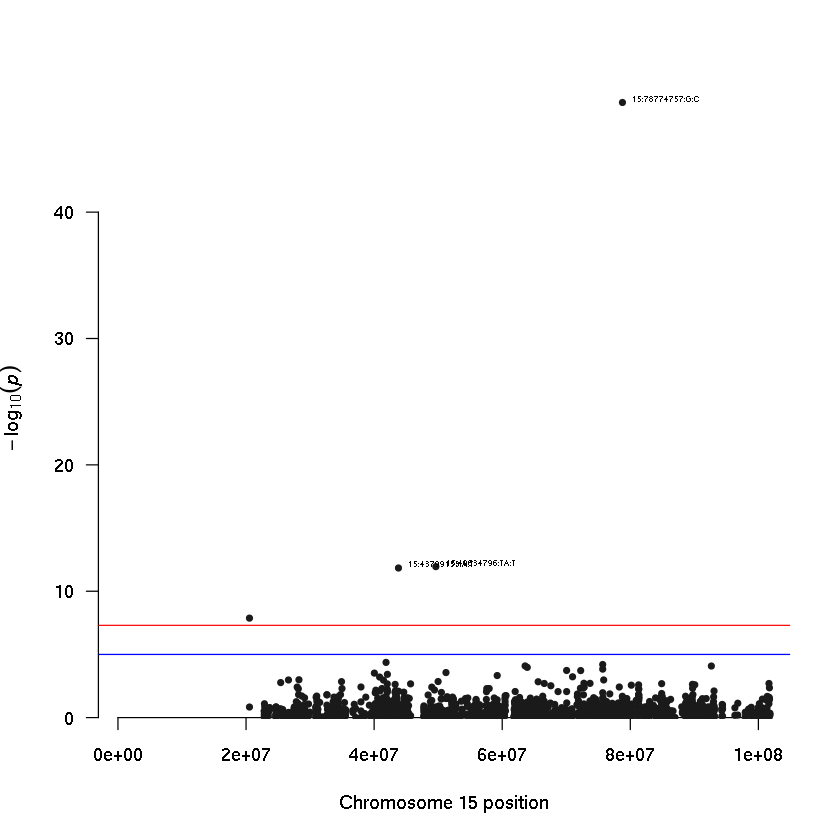

In [11]:
gwasres = gwasres[order(as.numeric(gwasres$P),decreasing = F),]
head(gwasres,30)
manhattan(subset(gwasres,CHR==1),annotateTop=F,annotatePval=1e-8)

In [3]:
# Add the gnomad ref
gnomad_ref = fread(
    "/oak/stanford/groups/euan/projects/elite/ukbb_exome/elite_filtered_vcfs/comp_freq_with_gnomad.all.tsv",
    data.table=F,stringsAsFactors=F)
head(gnomad_ref)

#CHROM,ID,REF,ALT,ALT_FREQS,OBS_CT,AF_fin,P_fin,AF_nfe,P_nfe
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1:10492:C:T,C,T,0.0542169,166,0.0106199,3.37410729853613e-07,0.0239781,0.0218455313158744
1,1:13273:G:C,G,C,0.177165,508,0.226696,0.00896685962448678,0.216508,0.0358060066230697
1,1:13289:CCT:C,CCT,C,0.00398406,502,0.000814553,0.158753685148409,0.00327099,1
1,1:14671:G:C,G,C,0.00943396,424,0.00722146,0.801600026494123,0.0151766,0.442126660101954
1,1:14907:A:G,A,G,0.341346,208,0.387016,0.200151962442784,0.368029,0.467801624694257
1,1:14930:A:G,A,G,0.402062,194,0.298551,0.00212590291319842,0.332197,0.0466109375842625


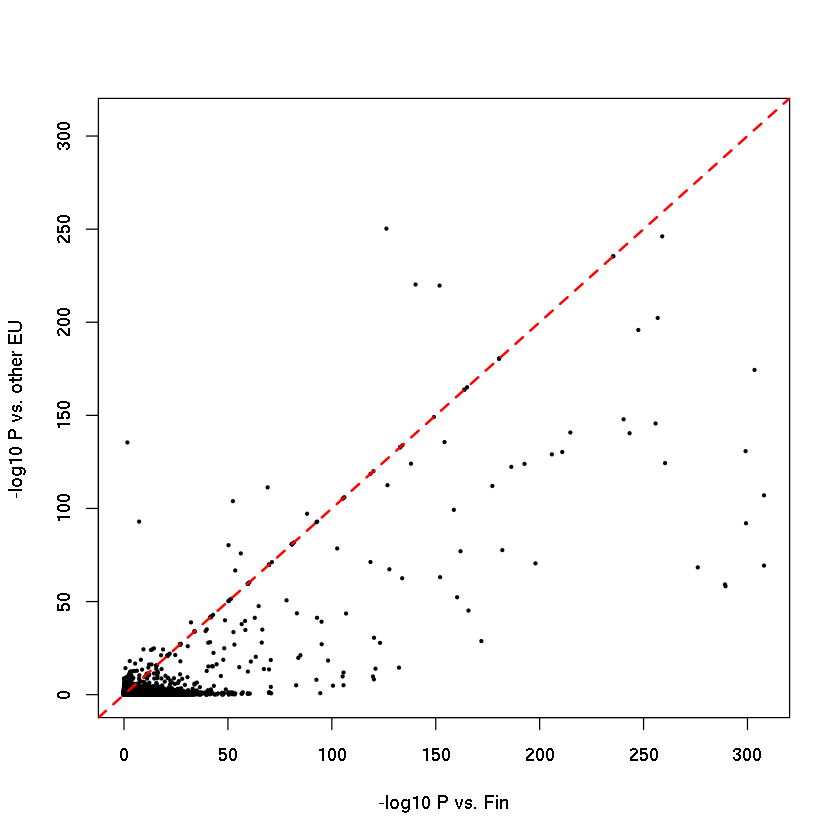

In [4]:
gnomad_ref_raw = gnomad_ref
gnomad_ref = gnomad_ref[gnomad_ref[["ID"]] %in% gwasres[["ID"]],]
rownames(gnomad_ref) = gnomad_ref[["ID"]]
#gnomad_shared = intersect(rownames(gnomad_ref),gwasres[["ID"]])
#length(gnomad_shared)
plot(-log10(as.numeric(gnomad_ref[["P_fin"]])),
     -log10(as.numeric(gnomad_ref[["P_nfe"]])),pch=20,cex=0.5,
    xlab = "-log10 P vs. Fin",ylab = "-log10 P vs. other EU")
abline(0,1,lwd=2,lty=2,col="red")

In [26]:
dim(gnomad_ref)
dim(gwasres)
gwasres = gwasres[gwasres[["ID"]] %in% gnomad_ref[["ID"]],]
rownames(gwasres) = gwasres[["ID"]]

[1] 72194    10

[1] 72195    14

Warning message in manhattan(gwasres2):
“No SNP column found. OK unless you're trying to highlight.”

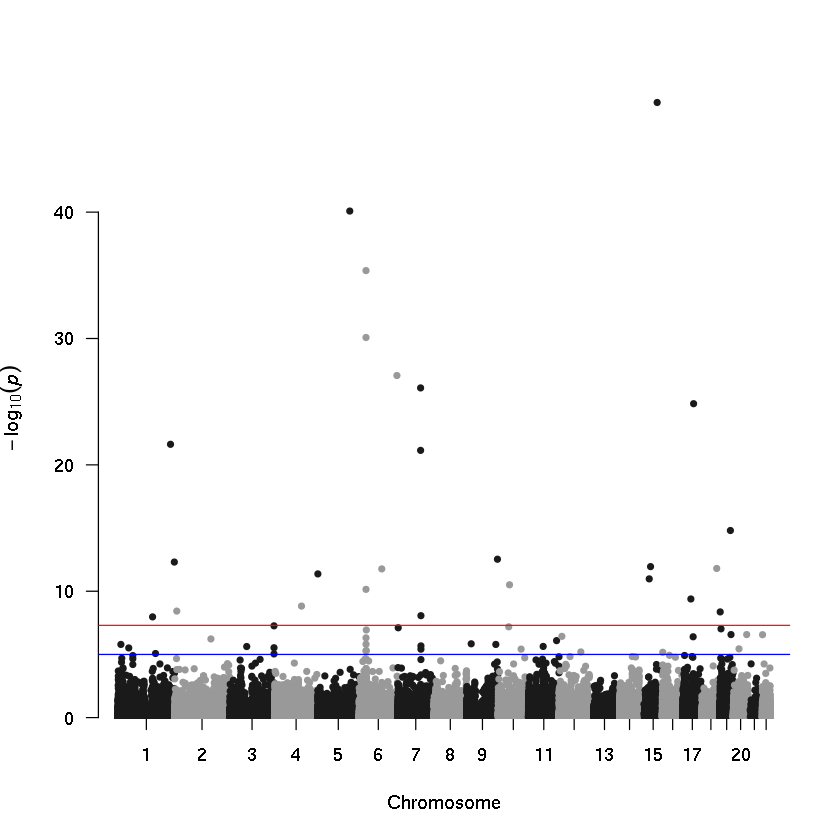

In [27]:
gnomad_ref = gnomad_ref[rownames(gwasres),]
gwasres2 = gwasres
gwasres2$P = pmax(as.numeric(gwasres$P),as.numeric(gnomad_ref[["P_nfe"]]))
gwasres2 = gwasres2[!is.na(gwasres2$P),]
manhattan(gwasres2)

In [28]:
selected_res = gwasres2[as.numeric(gwasres2$P)<5e-08,]
print(selected_res)

                   CHR        BP                 ID  REF ALT A1 FIRTH? TEST
15:78774757:G:C     15  78774757    15:78774757:G:C    G   C  C      N  ADD
5:141201394:T:G      5 141201394    5:141201394:T:G    T   G  G      N  ADD
6:167373202:G:A      6 167373202    6:167373202:G:A    G   A  A      N  ADD
6:31356399:C:G       6  31356399     6:31356399:C:G    C   G  G      N  ADD
7:101035412:T:C      7 101035412    7:101035412:T:C    T   C  C      N  ADD
6:31356203:A:G       6  31356203     6:31356203:A:G    A   G  G      N  ADD
7:101036479:G:A      7 101036479    7:101036479:G:A    G   A  A      N  ADD
17:47137265:G:A     17  47137265    17:47137265:G:A    G   A  A      N  ADD
1:231217589:G:GA     1 231217589   1:231217589:G:GA    G  GA GA      N  ADD
1:248039172:A:G      1 248039172    1:248039172:A:G    A   G  G      N  ADD
19:45795906:CCCT:C  19  45795906 19:45795906:CCCT:C CCCT   C  C      N  ADD
9:135098020:G:GA     9 135098020   9:135098020:G:GA    G  GA GA      N  ADD
15:49634796:

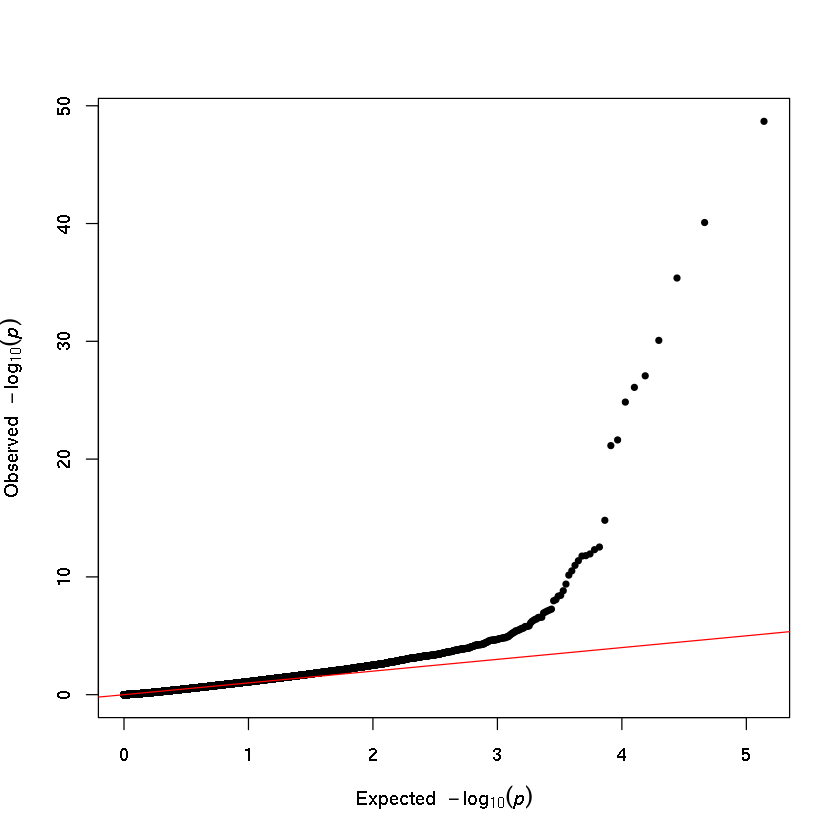

In [29]:
qq(gwasres2$P)

[1] 1

[1] 1.262464e-308

Warning message in manhattan(gwasres3):
“No SNP column found. OK unless you're trying to highlight.”

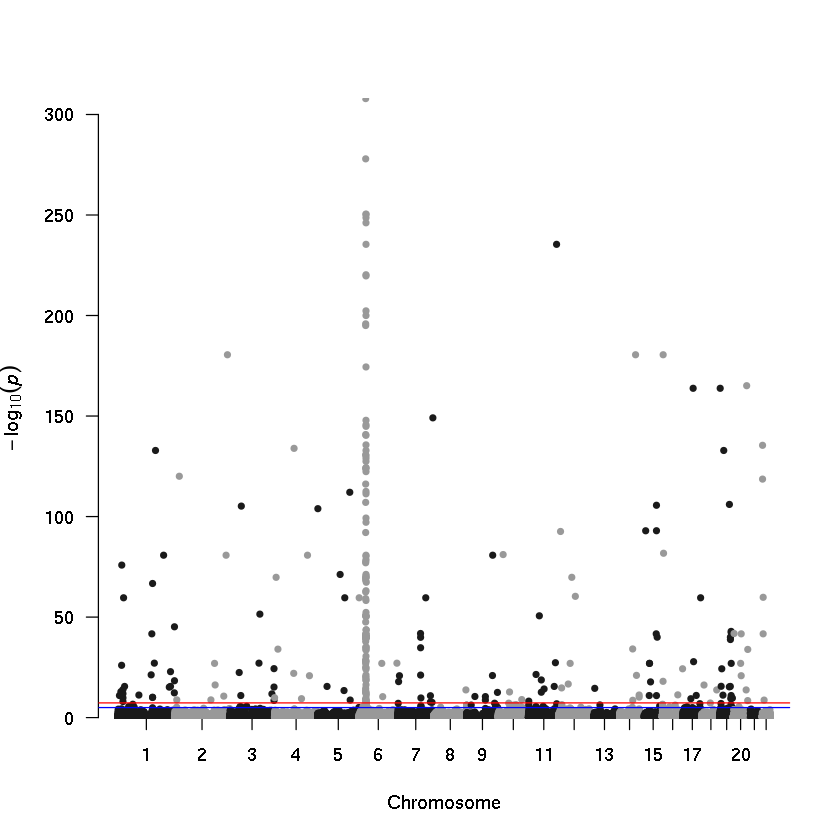

In [46]:
gwasres3 = gwasres
gwasres3$P = as.numeric(gnomad_ref[["P_nfe"]])
#head(gwasres3)
names(gwasres3)[ncol(gwasres3)] = "P"
gwasres3$P = as.numeric(gwasres3$P)
#hist(gwasres3$P)
gwasres3 = gwasres3[!is.na(gwasres3$P),]
gwasres3$P[gwasres3$P==1] = 1 - 1e-40
gwasres3$P[gwasres3$P==0] = 1e-40
max(gwasres3$P)
min(gwasres3$P)
manhattan(gwasres3)

Warning message in manhattan(gwasres3):
“No SNP column found. OK unless you're trying to highlight.”

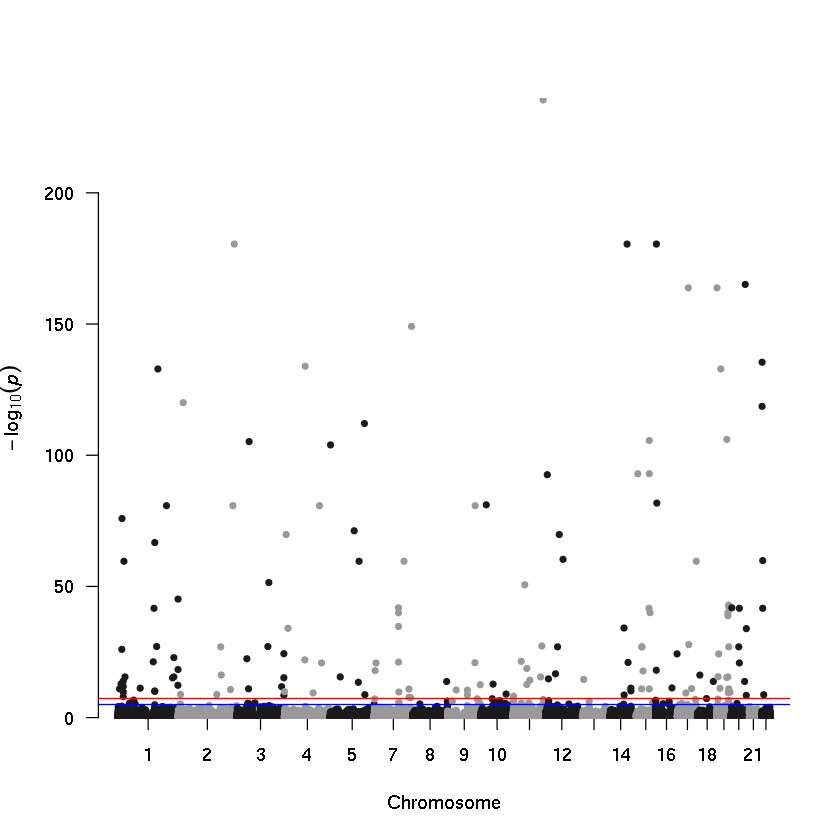

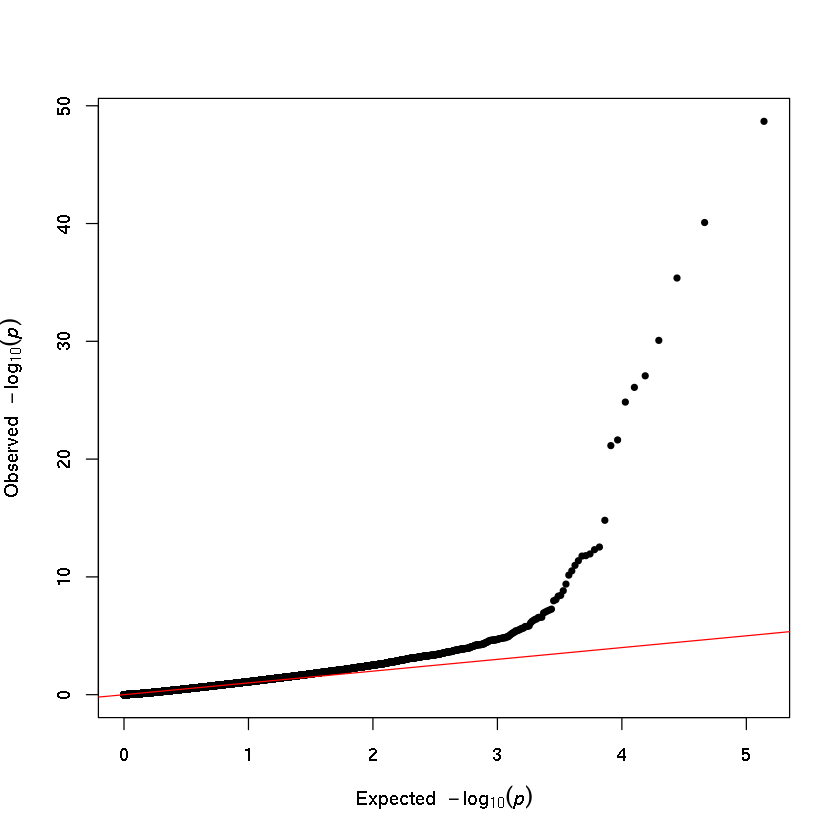

In [48]:
gwasres3 = gwasres3[gwasres3[,1]!=6,]
manhattan(gwasres3)

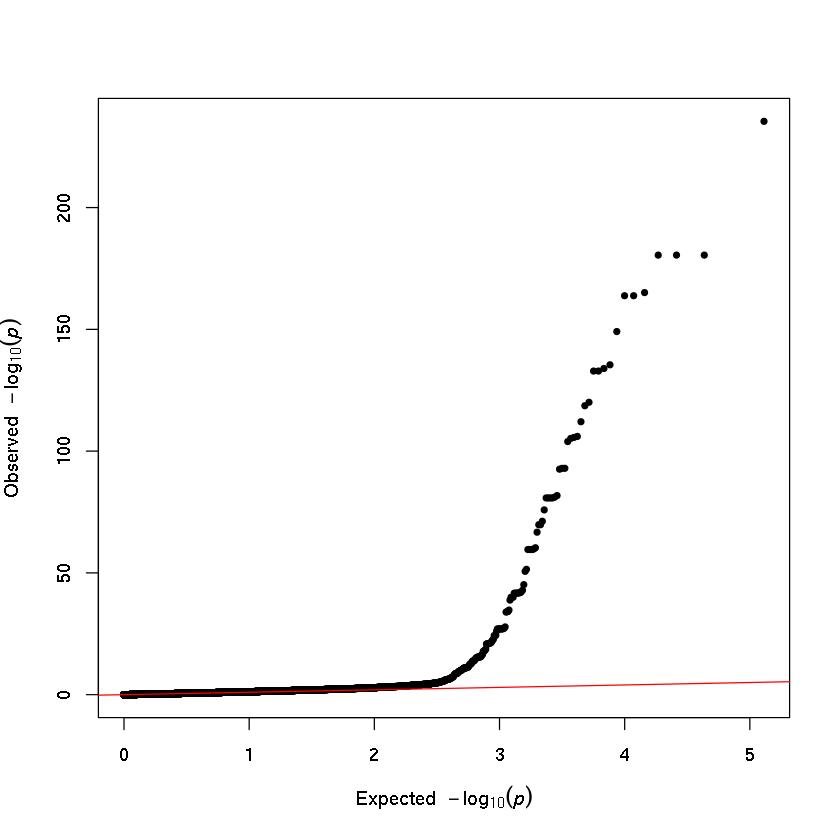

In [49]:
qq(gwasres3$P)

In [50]:
selected_res = gwasres3[as.numeric(gwasres3$P)<5e-08,]
print(selected_res)

                               CHR        BP                             ID
15:78774757:G:C                 15  78774757                15:78774757:G:C
5:141201394:T:G                  5 141201394                5:141201394:T:G
7:101035412:T:C                  7 101035412                7:101035412:T:C
7:101036479:G:A                  7 101036479                7:101036479:G:A
17:47137265:G:A                 17  47137265                17:47137265:G:A
1:231217589:G:GA                 1 231217589               1:231217589:G:GA
1:248039172:A:G                  1 248039172                1:248039172:A:G
19:45795906:CCCT:C              19  45795906             19:45795906:CCCT:C
9:135098020:G:GA                 9 135098020               9:135098020:G:GA
15:49634796:TA:T                15  49634796               15:49634796:TA:T
15:43799153:A:T                 15  43799153                15:43799153:A:T
18:65762831:G:GA                18  65762831               18:65762831:G:GA
5:837438:C:G

In [ ]:
# gnomAD analysis

In [5]:
gnomad_ref_filtered = gnomad_ref_raw[as.numeric(gnomad_ref_raw[["AF_nfe"]])>0.05,]
dim(gnomad_ref_filtered)

Warning message in `[.data.frame`(gnomad_ref_raw, as.numeric(gnomad_ref_raw[["AF_nfe"]]) > :
“NAs introduced by coercion”

[1] 2403007      10

In [6]:
head(gnomad_ref_filtered)

,#CHROM,ID,REF,ALT,ALT_FREQS,OBS_CT,AF_fin,P_fin,AF_nfe,P_nfe
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,1,1:13273:G:C,G,C,0.177165,508,0.226696,0.00896685962448678,0.216508,0.0358060066230697
5,1,1:14907:A:G,A,G,0.341346,208,0.387016,0.200151962442784,0.368029,0.467801624694257
6,1,1:14930:A:G,A,G,0.402062,194,0.298551,0.00212590291319842,0.332197,0.0466109375842625
14,1,1:61987:A:G,A,G,0.405488,328,0.521868,3.1239294661264e-05,0.539746,1.41354319344235e-06
15,1,1:61989:G:C,G,C,0.405488,328,0.522977,2.61236785961324e-05,0.539839,1.3892778163749e-06
16,1,1:62203:T:C,T,C,0.327731,238,0.435343,0.0010268809190949,0.492276,5.3663679572089e-07


In [9]:
colnames(gnomad_ref_filtered)[1] = "CHR"
colnames(gnomad_ref_filtered)[ncol(gnomad_ref_filtered)] = "P"
pos = sapply(gnomad_ref_filtered[["ID"]],function(x)strsplit(x,split=":")[[1]][2])
gnomad_ref_filtered$POS = pos

In [12]:
gnomad_ref_filtered$BP = as.numeric(gnomad_ref_filtered$POS)
gnomad_ref_filtered$CHR = as.numeric(gnomad_ref_filtered$CHR)
gnomad_ref_filtered$P = as.numeric(gnomad_ref_filtered$P)

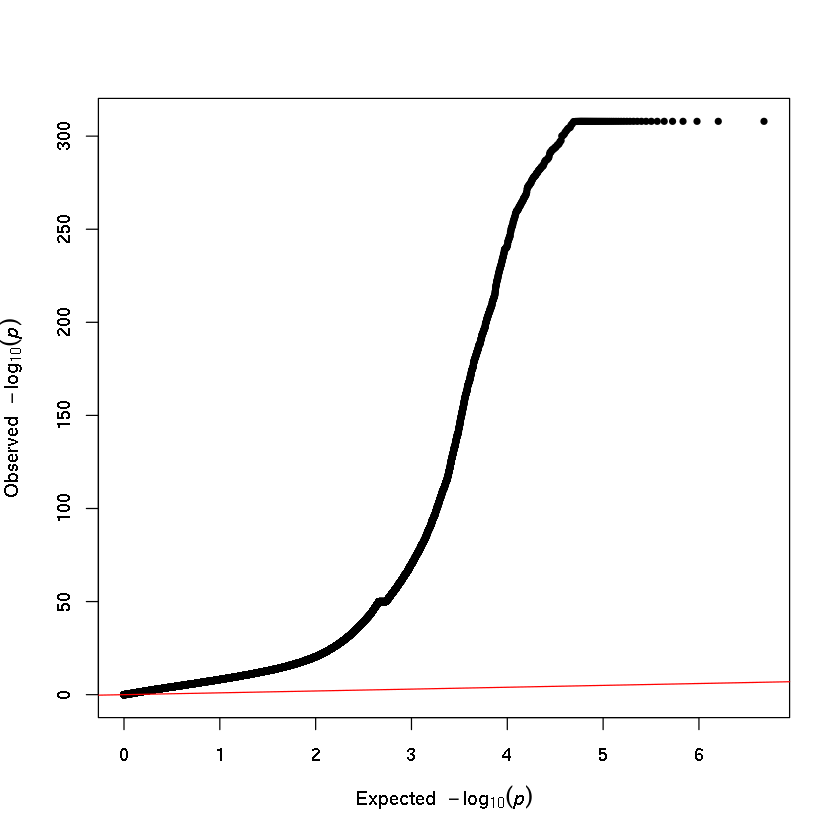

In [15]:
gnomad_ref_filtered = gnomad_ref_filtered[!is.na(gnomad_ref_filtered$P),]
gnomad_ref_filtered$P[gnomad_ref_filtered$P==1] = 1-1e-50
gnomad_ref_filtered$P[gnomad_ref_filtered$P==0] = 1e-50
qq(gnomad_ref_filtered$P)